In [5]:

import requests
from bs4 import BeautifulSoup
import pandas as pd
import yaml
import time
import re
import urllib.parse
from lyricsgenius import Genius
import os
import unittest
import demoji
import numpy as np
import pycountry
from ftlangdetect import detect
import matplotlib.pyplot as plt
import seaborn as sns


## get artists from playlists

In [601]:

def get_spotify_keys():
    with open('keys/spotify_keys.yml', 'r') as file:
        spotify_keys = yaml.safe_load(file)

    return spotify_keys['id'], spotify_keys['secret']

def get_spotify_access(CLIENT_ID, CLIENT_SECRET):
    AUTH_URL = 'https://accounts.spotify.com/api/token'

    # POST
    auth_response = requests.post(AUTH_URL, {
        'grant_type': 'client_credentials',
        'client_id': CLIENT_ID,
        'client_secret': CLIENT_SECRET,
    })

    # convert the response to JSON
    auth_response_data = auth_response.json()
    print('Spotify ACCESS_TOKEN obtained. Token expires in', auth_response_data['expires_in'], 'seconds')

    # save the access token
    access_token = auth_response_data['access_token']

    return access_token

def call_spotify_api(url, headers):
    response = requests.get(url, headers=headers)

    if (response.status_code == 200):
        time.sleep(1)
        return response.json()
    elif (response.status_code == 401):
        print('[ERROR] Response status code 401 - waiting 30 sec')
        time.sleep(30)
        return None


def get_spotify_playlist(headers, content_uri):

    response_size = -1
    index = 0

    data = {'artist':[], 'id':[]}

    while (response_size!=0):

        url = 'https://api.spotify.com/v1/playlists/' + content_uri + '/tracks?limit=50&offset='+str(index)
        json_content = call_spotify_api(url, headers)

        if (json_content != None):
            items = json_content['items']
            response_size = len(items)

            for item in items:
                info = item['track']['artists'][0]

                data['artist'] += [info['name']]
                data['id'] += [info['id']]

            index += 50
            time.sleep(1)

    return data


def get_spotify_content(get_content_function, access_token, content_uri):

    headers = {
        'Authorization': 'Bearer {token}'.format(token=access_token)
    }
    content = get_content_function(headers, content_uri)

    return content


In [602]:

CLIENT_ID, CLIENT_SECRET = get_spotify_keys()
access_token = get_spotify_access(CLIENT_ID, CLIENT_SECRET)
# access_token = 'BQBzRnezTrbBvw-fgcIAjXQffqcMgTUBpcvbtVAV-z_Fp8FHeDiZFcrJ9PDCm9l2qB-hBU_t4CcGN7dlzOCP12DrrDnKq68K3ZwS34ECxEdQE9rve88'
# access_token = 'BQCKebW_cdw_YOjpH41ELgbraH3xo9zO3i-FKCvGn5Uq3NJV7D7T0KJvEJM5y91mRYAb1uhN34P2-w5gYbVtv5doY7z35khQq-FyeLQAZpG90ys380U'


# REMEMBER: these playlists are live and some change every couple of days or hours
spotify_playlists = {
    'Industrial Metal': '37i9dQZF1DX29LQDcJ6Xy7',
    'INDUSTRIAL METAL': '0I4fAd7K0zIHBJYNw9fSuv',
    'Heavy Metal': '37i9dQZF1DX9qNs32fujYe',
    'Metal Mix': '37i9dQZF1EQpgT26jgbgRI',
    'Aggressive Heavy Metal Mix': '37i9dQZF1EIetewBshGEPK',
    'Death Metal Mix': '37i9dQZF1EIf78r65WuXwA',
    'Death Metal Melodico': '5LXjHUJXPJIW71ySYppK5J',
    'Death Metal': '2vivknVOeJD7BUYnnuztrE',
    'Hard Rock': '37i9dQZF1DX1X7WV84927n',
    'Hard Rock / Metal': '1GXRoQWlxTNQiMNkOe7RqA',
    'Hard Rock Mix': '37i9dQZF1EIehdyB47Vd7I',
    'Metalcore Mix': '37i9dQZF1EIgtj4OvJCT7Q',
    '2023 Metalcore Playlist': '7IUlbEWRYOKeTZKmjBcRgX',
    'Modern Metalcore': '4ge2kKhU0ryYD1BWN1CX2T',
    'Deathcore': '37i9dQZF1DX1cJWWyylDuw',
    'Melodic Metal Mix': '37i9dQZF1EId4LkhIN52c3',
    'Epic and Melodic': '37i9dQZF1DX37bXS7EGI3f',
    'Melodic Death Metal Mix': '37i9dQZF1EIfs512qHK0fg',
    'Grindcore Mix': '37i9dQZF1EIgFHBMi7n4aZ',
    'Power Metal Mix': '37i9dQZF1EIfUrKSfi4vkq',
    'power metal': '6uD6LqbKgMn036cfvniRO6',
    'BLACK METAL': '37i9dQZF1EIdrDO1pClEMb',
    'black metal classics': '688iTCqxHbpNbBuWplfa17',
    'Nu Metal Era': '37i9dQZF1DXcfZ6moR6J0G',
    'Nu Metal Mix': '37i9dQZF1EIdT6waU1nlDF',
    'Nu Metal Hits': '37i9dQZF1EIdT6waU1nlDF',
    'Ultimate Goth Metal': '1DR4lUIiCmTYWrxmMNSoyd',
    'Gothic Metal': '76PSrknbBdEiQxvoinpYAm',
    'Groove Metal Mix': '37i9dQZF1EIcCL8b99YRCA',
    'Ultimate Groove Metal': '24y2slE56YDOTR2t4Zr1lR',
    'Rock Mix': '37i9dQZF1EQpj7X7UK8OOF',
    'Best of Rock 2000': '37i9dQZF1DX6rsDrBNGuWW',
    'Pop Hits 2000s - 2023': '6mtYuOxzl58vSGnEDtZ9uB',
    'Pop Hits 2023': '5TDtuKDbOhrfW7C58XnriZ',
    'Pop Mix': '37i9dQZF1EQncLwOalG3K7'
}


Spotify ACCESS_TOKEN obtained. Token expires in 3600 seconds


In [603]:

results_dict = {}

for playlist in spotify_playlists:
    print('processing:', playlist)
    content_uri = spotify_playlists[playlist]
    content = get_spotify_content(get_spotify_playlist, access_token, content_uri)

    results_dict[playlist] = content
print('DONE...')


processing: Industrial Metal
processing: INDUSTRIAL METAL
processing: Heavy Metal
processing: Metal Mix
processing: Aggressive Heavy Metal Mix
processing: Death Metal Mix
processing: Death Metal Melodico
processing: Death Metal
processing: Hard Rock
processing: Hard Rock / Metal
processing: Hard Rock Mix
processing: Metalcore Mix
processing: 2023 Metalcore Playlist
processing: Modern Metalcore
processing: Deathcore
processing: Melodic Metal Mix
processing: Epic and Melodic
processing: Melodic Death Metal Mix
processing: Grindcore Mix
processing: Power Metal Mix
processing: power metal
processing: BLACK METAL
processing: black metal classics
processing: Nu Metal Era
processing: Nu Metal Mix
processing: Nu Metal Hits
processing: Ultimate Goth Metal
processing: Gothic Metal
processing: Groove Metal Mix
processing: Ultimate Groove Metal
processing: Rock Mix
processing: Best of Rock 2000
processing: Pop Hits 2000s - 2023
processing: Pop Hits 2023
processing: Pop Mix
DONE...


In [604]:

artists_df = pd.DataFrame.from_dict({})

for results in results_dict:
    tmp_df = pd.DataFrame.from_dict(results_dict[results])
    artists_df = pd.concat([artists_df, tmp_df])

print(len(artists_df))
artists_df = artists_df.drop_duplicates()
artists_df = artists_df.dropna()
print(len(artists_df))

# artists_df.to_csv('artists.csv', sep=';', index=False)
artists_df.head(10)


4244
1139


,artist,id
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj
2,Fear Factory,74Hj7BmnUXyx2udrIEIKwX
3,Rammstein,6wWVKhxIU2cEi0K81v7HvP
4,Dope,7fWgqc4HJi3pcHhK8hKg2p
5,Filter,01WjpKiWVNurV5hjIadB8C
6,Static-X,7JDSHlDdVTo7aZKdQZ53Vf
7,Orgy,4uYwLU7k03RCQSRXGtQGg0
9,Skillet,49bzE5vRBRIota4qeHtQM8
10,Nine Inch Nails,0X380XXQSNBYuleKzav5UO


## get kaggle data

In [605]:

kaggle_spotify_file = "input_data/dataset.csv"
kaggle_youtube_file = "input_data/Spotify_Youtube.csv"

kaggle_spot_df = pd.read_csv(kaggle_spotify_file)
kaggle_spot_df = kaggle_spot_df[['artists', 'track_genre']]

kaggle_spot_df = kaggle_spot_df.groupby(['artists']).apply(lambda x: x['track_genre'].unique())
kaggle_spot_df = kaggle_spot_df.reset_index(name='track_genre')

kaggle_spot_df = kaggle_spot_df.set_index(['track_genre']).apply(lambda x: x.str.split(',').explode())
kaggle_spot_df = kaggle_spot_df.reset_index()

kaggle_yout_df = pd.read_csv(kaggle_youtube_file)
kaggle_yout_df = kaggle_yout_df

kaggle_tracks_df = kaggle_yout_df.merge(kaggle_spot_df, left_on='Artist', right_on='artists', how='inner')
kaggle_tracks_df = kaggle_tracks_df[['Artist', 'Url_spotify', 'Track', 'track_genre', 'Uri', 'Stream', 'Views', 'Likes', 'Comments', 'Description']]
kaggle_tracks_df.head()


,Artist,Url_spotify,Track,track_genre,Uri,Stream,Views,Likes,Comments,Description
0,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Feel Good Inc.,"[alternative, hip-hop]",spotify:track:0d28khcov6AiegSCpG5TuT,1.040235e+09,693555221.0,6220896.0,169907.0,Official HD Video for Gorillaz' fantastic trac...
1,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Rhinestone Eyes,"[alternative, hip-hop]",spotify:track:1foMv2HQwfQ2vntFf9HFeG,3.100837e+08,72011645.0,1079128.0,31003.0,The official video for Gorillaz - Rhinestone E...
2,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,New Gold (feat. Tame Impala and Bootie Brown),"[alternative, hip-hop]",spotify:track:64dLd6rVqDLtkXFYrEUHIU,6.306347e+07,8435055.0,282142.0,7399.0,Gorillaz - New Gold ft. Tame Impala & Bootie B...
3,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,On Melancholy Hill,"[alternative, hip-hop]",spotify:track:0q6LuUqGLUiCPP1cbdwFs3,4.346636e+08,211754952.0,1788577.0,55229.0,Follow Gorillaz online:\nhttp://gorillaz.com \...
4,Gorillaz,https://open.spotify.com/artist/3AA28KZvwAUcZu...,Clint Eastwood,"[alternative, hip-hop]",spotify:track:7yMiX7n9SBvadzox8T5jzT,6.172597e+08,618480958.0,6197318.0,155930.0,The official music video for Gorillaz - Clint ...


In [606]:

def contains_similar_genre(values, genres):
    for value in values:
        for genre in genres:
            if (value in genre):
                return True
    return False

genre_filter = kaggle_tracks_df['track_genre'].apply(lambda x: contains_similar_genre(x, ['metal', 'rock', 'pop']))
kaggle_tracks_df = kaggle_tracks_df[genre_filter]

kaggle_tracks_df.head()


,Artist,Url_spotify,Track,track_genre,Uri,Stream,Views,Likes,Comments,Description
10,Red Hot Chili Peppers,https://open.spotify.com/artist/0L8ExT028jH3dd...,Californication,"[alt-rock, alternative, funk, metal, rock]",spotify:track:48UPSzbZjgc449aqz8bxox,1.055738e+09,1.018811e+09,4394471.0,121452.0,Watch the official music video for Californica...
11,Red Hot Chili Peppers,https://open.spotify.com/artist/0L8ExT028jH3dd...,Under the Bridge,"[alt-rock, alternative, funk, metal, rock]",spotify:track:3d9DChrdc6BOeFsbrZ3Is0,1.061751e+09,2.466877e+08,1213572.0,32761.0,Watch the official music video for Under The B...
12,Red Hot Chili Peppers,https://open.spotify.com/artist/0L8ExT028jH3dd...,Can't Stop,"[alt-rock, alternative, funk, metal, rock]",spotify:track:3ZOEytgrvLwQaqXreDs2Jx,8.664650e+08,3.366358e+08,1740224.0,32573.0,Watch the official music video for Can't Stop ...
13,Red Hot Chili Peppers,https://open.spotify.com/artist/0L8ExT028jH3dd...,Scar Tissue,"[alt-rock, alternative, funk, metal, rock]",spotify:track:1G391cbiT3v3Cywg8T7DM1,6.138387e+08,4.351215e+08,1890900.0,37069.0,Watch the official music video for Scar Tissue...
14,Red Hot Chili Peppers,https://open.spotify.com/artist/0L8ExT028jH3dd...,Otherside,"[alt-rock, alternative, funk, metal, rock]",spotify:track:64BbK9SFKH2jk86U3dGj2P,7.327745e+08,6.735287e+08,3140356.0,60091.0,Watch the official music video for Otherside b...


In [607]:

kaggle_tracks_df['Url_spotify'] = kaggle_tracks_df['Url_spotify'].str.split('/').str[-1]
kaggle_tracks_df['Uri'] = kaggle_tracks_df['Uri'].str.split(':').str[-1]

cols = list(kaggle_tracks_df)
for col in cols:
    kaggle_tracks_df.rename(columns={col:col.lower()}, inplace=True)

kaggle_tracks_df.rename(columns={'url_spotify':'id'}, inplace=True)
kaggle_tracks_df.rename(columns={'uri':'track_id'}, inplace=True)


In [608]:

tmp_df = artists_df.copy()
tmp_df = pd.concat([tmp_df, kaggle_tracks_df[['artist', 'id']]])

print('spotify dataframe:\t\t\t\t', len(artists_df), 'artists')
print('kaggle dataframe:\t\t\t\t', len(kaggle_tracks_df), 'artists')
print('concatenated dataframe:\t\t\t\t', len(tmp_df), 'artists')

artists_df = tmp_df.drop_duplicates()
print('concatenated dataframe (drop duplicates):\t', len(artists_df), 'artists')


spotify dataframe:				 1139 artists
kaggle dataframe:				 2859 artists
concatenated dataframe:				 3998 artists
concatenated dataframe (drop duplicates):	 1299 artists


## get artist tracks

In [614]:

def get_text_between(text, start_str, end_str):

    i_start_list = [m.start() for m in re.finditer(start_str, text)]
    i_end_list = [m.start() for m in re.finditer(end_str, text)]

    results = []

    try:
        for i in range(len(i_start_list)):
            if (i >= len(i_end_list)):
                break
            i_start = i_start_list[i] + len(start_str)
            i_end = i_end_list[i]
            results += [text[i_start:i_end]]
        return results

    except Exception as e:
        print('Something went wrong:', e)
        return []


def get_artist_contents(soup):

    # Get monthly listeners
    monthly_listeners_div = soup.find('div', {'data-encore-id': 'type'})
    if (monthly_listeners_div != None):
        monthly_listeners = monthly_listeners_div.text
    else:
        monthly_listeners = None

    # Get top tracks
    start_str = '<span class="ListRowTitle__LineClamp-sc-1xe2if1-0 jjpOuK">'
    end_str = '</span></p></span>'
    top_tracks = get_text_between(str(soup), start_str, end_str)

    # Get top track listens
    start_str = 'data-encore-id="type" id="listrow-subtitle-track-spotify:track:'
    end_str = '</p></div><div class="Areas__InteractiveArea-sc-8gfrea-0 Areas__TrailingSlot-sc-8gfrea-7 bJSfgC jpzxju">'
    top_listens = get_text_between(str(soup), start_str, end_str)

    # Get top track links
    start_str = '"RowMouseLink-sc-hvecl1-0 fKlqHK" data-testid="mouse-only-link"></div><div id="onClickHinttrack-spotify:track:'
    end_str = '" style="display:none"></div><div class="Areas__HeaderSideArea-sc-8gfrea-1'
    top_ids = get_text_between(str(soup), start_str, end_str)
    top_ids = [tl[0:-2] for tl in top_ids]

    # Get description
    start_str = '<span class="Type__TypeElement-sc-goli3j-0 bGROfl G_f5DJd2sgHWeto5cwbi" data-encore-id="type">'
    end_str = '</span></p></div></div></div>'
    desc = get_text_between(str(soup), start_str, end_str)

    end_str = '</span><button aria-expanded="false" class="UhoFLV9F6uYQvi0m6ptf">'
    desc_exand = get_text_between(str(soup), start_str, end_str)

    if (len(desc_exand) > len(desc)):
        desc = desc_exand

    # Create output dict
    content_dict = {
        'monthly_listeners': monthly_listeners,
        'top_tracks': top_tracks,
        'top_listens': top_listens,
        'top_ids': top_ids,
        'desc': desc
    }

    if (
        (
            len(content_dict['top_tracks'])==
            len(content_dict['top_listens'])==
            len(content_dict['top_ids'])
        ) and (
            monthly_listeners != None
        )
    ):
        return content_dict
    else:
        return None


def process_page(url, function):

    headers = {
        'User-Agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
        'Accept-Language': 'en-US, en;q=0.5'
    }

    headers = ()
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    return function(soup)
    


In [615]:

artist_scrape_dict = {}

print('Fetching artists\' page information. This could take a few minutes...')
for i in range(len(artists_df)):

    if (i%100==0):
        print(i, 'of', len(artists_df), 'artists\' pages processed...' )

    artist = artists_df.iloc[i]
    artist_name = artist['artist']
    artist_id = artist['id']

    artist_url = 'https://open.spotify.com/artist/'+artist_id
    content_dict = process_page(artist_url, get_artist_contents)

    if (content_dict != None):
        artist_scrape_dict[artist_name] = content_dict

    time.sleep(1)
print('DONE...')


Fetching artists' page information. This could take a few minutes...
0 of 1299 artists' pages processed...
100 of 1299 artists' pages processed...
200 of 1299 artists' pages processed...
300 of 1299 artists' pages processed...
400 of 1299 artists' pages processed...
500 of 1299 artists' pages processed...
600 of 1299 artists' pages processed...
700 of 1299 artists' pages processed...
800 of 1299 artists' pages processed...
900 of 1299 artists' pages processed...
1000 of 1299 artists' pages processed...
1100 of 1299 artists' pages processed...
1200 of 1299 artists' pages processed...
DONE...


In [616]:

track_info_dict = {
    'artist':[],
    'track':[],
    'track_id':[],
    'track_listens':[]
}

artist_info_dict = {
    'artist':[],
    'monthly_listeners':[],
    'description':[]
}

for artist in artist_scrape_dict:
    data = artist_scrape_dict[artist]

    # Append to artist dictionary
    artist_info_dict['artist'] += [artist]
    artist_info_dict['monthly_listeners'] += [data['monthly_listeners']]

    desc = data['desc']
    if (len(desc) == 0):
        desc = None
    else:
        desc = desc[0]
    artist_info_dict['description'] += [desc]

    # Append to track dictionary
    for track in data['top_tracks']:
        track_info_dict['artist'] += [artist]
        track_info_dict['track'] += [track]

    for track_id in data['top_ids']:
        track_info_dict['track_id'] += [track_id]

    for track_listens in data['top_listens']:
        track_info_dict['track_listens'] += [track_listens]


In [620]:

tracks_df = pd.DataFrame.from_dict(track_info_dict)
# tracks_df.to_csv('tracks_df.csv', sep=';', index=False)
tracks_df.head()


,artist,track,track_id,track_listens
0,Rob Zombie,Dragula,6Nm8h73ycDG2saCnZV8poF,"6Nm8h73ycDG2saCnZV8poF-0"">331,646,321"
1,Rob Zombie,Living Dead Girl,10V8XpuyMoEcSMfM79WDET,"10V8XpuyMoEcSMfM79WDET-1"">130,584,774"
2,Rob Zombie,Superbeast,4eNnMvUrSu2TRpySjVC0Pv,"4eNnMvUrSu2TRpySjVC0Pv-2"">91,715,788"
3,Rob Zombie,Feel So Numb,6KnNDix4Owr4vNmsPhLmxD,"6KnNDix4Owr4vNmsPhLmxD-3"">54,587,702"
4,Rob Zombie,The Satanic Rites of Blacula,1JeGX4cixemJfBJl6XGQES,"1JeGX4cixemJfBJl6XGQES-4"">10,284,300"


In [623]:

artists_info_df = pd.DataFrame.from_dict(artist_info_dict)
# artists_info_df.to_csv('artist_info.csv', sep=';', index=False)
artists_info_df.head()


,artist,monthly_listeners,description
0,Rob Zombie,"5,758,128 monthly listeners",The longtime frontman for '90s industrial supe...
1,Marilyn Manson,"6,735,459 monthly listeners",Controversial rock frontman Marilyn Manson bec...
2,Fear Factory,"974,109 monthly listeners",One can’t overstate the size of the Fear Facto...
3,Rammstein,"10,661,005 monthly listeners",Rammstein are one of rock’s most individual an...
4,Dope,"1,734,951 monthly listeners",New album 'Blood Money Part Zer0' out 2.24.23!


In [624]:

artists_df = artists_df.merge(artists_info_df, on='artist')
artists_df.head()


,artist,id,monthly_listeners,description
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,"5,758,128 monthly listeners",The longtime frontman for '90s industrial supe...
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj,"6,735,459 monthly listeners",Controversial rock frontman Marilyn Manson bec...
2,Fear Factory,74Hj7BmnUXyx2udrIEIKwX,"974,109 monthly listeners",One can’t overstate the size of the Fear Facto...
3,Rammstein,6wWVKhxIU2cEi0K81v7HvP,"10,661,005 monthly listeners",Rammstein are one of rock’s most individual an...
4,Dope,7fWgqc4HJi3pcHhK8hKg2p,"1,734,951 monthly listeners",New album 'Blood Money Part Zer0' out 2.24.23!


## Get track features

In [628]:

def get_spotify_tracks(headers, content_uri):

    batch_size = 50
    batch_index = 0

    info_dict = {
        'track_id':[],
        'popularity':[],
        'artist_id':[]
    }
    feat_dict = {
        'track_id':[],
        'danceability':[],
        'energy':[],
        'key':[],
        'loudness':[],
        'mode':[],
        'speechiness':[],
        'acousticness':[],
        'instrumentalness':[],
        'liveness':[],
        'valence':[],
        'tempo':[],
        'time_signature':[]
    }

    print('Processing tracks. This could take a few minutes...')
    while True:

        if (batch_index%1000 == 0):
            print('\ttracks processed:', batch_index, 'of', len(content_uri))

        tracks_ids = content_uri[batch_index:batch_index+batch_size]

        info_url = 'https://api.spotify.com/v1/tracks?ids=' + '%2C'.join(tracks_ids)
        json_track_info = call_spotify_api(info_url, headers)

        features_url = 'https://api.spotify.com/v1/audio-features?ids='+ '%2C'.join(tracks_ids)
        json_track_feat = call_spotify_api(features_url, headers)

        if (json_track_info != None and json_track_feat != None):
            for track in json_track_info['tracks']:
                info_dict['track_id'] += [track['id']]
                info_dict['popularity'] += [track['popularity']]
                info_dict['artist_id'] += [track['artists'][0]['id']]

            for track in json_track_feat['audio_features']:
                feat_dict['track_id'] += [track['id']]
                feat_dict['danceability'] += [track['danceability']]
                feat_dict['energy'] += [track['energy']]
                feat_dict['key'] += [track['key']]
                feat_dict['loudness'] += [track['loudness']]
                feat_dict['mode'] += [track['mode']]
                feat_dict['speechiness'] += [track['speechiness']]
                feat_dict['acousticness'] += [track['acousticness']]
                feat_dict['instrumentalness'] += [track['instrumentalness']]
                feat_dict['liveness'] += [track['liveness']]
                feat_dict['valence'] += [track['valence']]
                feat_dict['tempo'] += [track['tempo']]
                feat_dict['time_signature'] += [track['time_signature']]

            batch_index += batch_size
        else:
            break

        time.sleep(1)

    print('DONE...')
    return info_dict, feat_dict


In [629]:

tracks_ids = pd.concat([tracks_df['track_id'], kaggle_tracks_df['track_id']])
tracks_ids = tracks_ids.drop_duplicates()
tracks_ids_list = tracks_ids.tolist()

access_token = get_spotify_access(CLIENT_ID, CLIENT_SECRET)
info_dict, feat_dict = get_spotify_content(get_spotify_tracks, access_token, tracks_ids_list)


Spotify ACCESS_TOKEN obtained. Token expires in 3600 seconds
Processing tracks. This could take a few minutes...
	tracks processed: 0 of 8079
	tracks processed: 1000 of 8079
	tracks processed: 2000 of 8079
	tracks processed: 3000 of 8079
	tracks processed: 4000 of 8079
	tracks processed: 5000 of 8079
	tracks processed: 6000 of 8079
	tracks processed: 7000 of 8079
	tracks processed: 8000 of 8079
DONE...


In [630]:

track_info_df = pd.DataFrame.from_dict(info_dict)
track_feat_df = pd.DataFrame.from_dict(feat_dict)
track_details_df = track_info_df.merge(track_feat_df, on='track_id')
track_details_df.head()


,track_id,popularity,artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,6Nm8h73ycDG2saCnZV8poF,80,3HVdAiMNjYrQIKlOGxoGh5,0.591,0.963,0,-6.489,0,0.0531,0.000087,0.000107,0.0781,0.609,125.030,4
1,10V8XpuyMoEcSMfM79WDET,72,3HVdAiMNjYrQIKlOGxoGh5,0.518,0.948,6,-5.580,0,0.0683,0.005040,0.104000,0.2280,0.550,103.025,4
2,4eNnMvUrSu2TRpySjVC0Pv,68,3HVdAiMNjYrQIKlOGxoGh5,0.518,0.975,8,-4.425,1,0.0575,0.000136,0.827000,0.4200,0.320,154.059,4
3,6KnNDix4Owr4vNmsPhLmxD,66,3HVdAiMNjYrQIKlOGxoGh5,0.566,0.889,8,-5.220,1,0.0426,0.000043,0.009070,0.2920,0.141,127.045,4
4,1JeGX4cixemJfBJl6XGQES,64,3HVdAiMNjYrQIKlOGxoGh5,0.480,0.993,0,-6.402,0,0.0862,0.000339,0.000050,0.3000,0.589,154.991,4


In [641]:

spotify_detail_df = tracks_df.merge(track_details_df, on='track_id', how='inner')
kaggle_detail_df = kaggle_tracks_df.merge(track_details_df, on='track_id', how='inner')
kaggle_detail_df.drop(columns=['track_genre', 'id', 'description'], inplace=True)
kaggle_detail_df.rename(columns={'stream': 'track_listens'}, inplace=True)


In [642]:

print('Spotify scraped tracks dataframe:', len(spotify_detail_df))
spotify_detail_df.head(3)


Spotify scraped tracks dataframe: 6374


,artist,track,track_id,track_listens,popularity,artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Rob Zombie,Dragula,6Nm8h73ycDG2saCnZV8poF,"6Nm8h73ycDG2saCnZV8poF-0"">331,646,321",80,3HVdAiMNjYrQIKlOGxoGh5,0.591,0.963,0,-6.489,0,0.0531,0.000087,0.000107,0.0781,0.609,125.030,4
1,Rob Zombie,Living Dead Girl,10V8XpuyMoEcSMfM79WDET,"10V8XpuyMoEcSMfM79WDET-1"">130,584,774",72,3HVdAiMNjYrQIKlOGxoGh5,0.518,0.948,6,-5.580,0,0.0683,0.005040,0.104000,0.2280,0.550,103.025,4
2,Rob Zombie,Superbeast,4eNnMvUrSu2TRpySjVC0Pv,"4eNnMvUrSu2TRpySjVC0Pv-2"">91,715,788",68,3HVdAiMNjYrQIKlOGxoGh5,0.518,0.975,8,-4.425,1,0.0575,0.000136,0.827000,0.4200,0.320,154.059,4


In [643]:

print('Kaggle tracks dataframe:', len(kaggle_detail_df))
kaggle_detail_df.head(3)


Kaggle tracks dataframe: 2859


,artist,track,track_id,track_listens,views,likes,comments,popularity,artist_id,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,Red Hot Chili Peppers,Californication,48UPSzbZjgc449aqz8bxox,1.055738e+09,1.018811e+09,4394471.0,121452.0,85,0L8ExT028jH3ddEcZwqJJ5,0.592,...,9,-2.788,0,0.0270,0.0021,0.001650,0.127,0.328,96.483,4
1,Red Hot Chili Peppers,Under the Bridge,3d9DChrdc6BOeFsbrZ3Is0,1.061751e+09,2.466877e+08,1213572.0,32761.0,84,0L8ExT028jH3ddEcZwqJJ5,0.559,...,4,-13.496,1,0.0459,0.0576,0.000105,0.141,0.458,84.581,4
2,Red Hot Chili Peppers,Can't Stop,3ZOEytgrvLwQaqXreDs2Jx,8.664650e+08,3.366358e+08,1740224.0,32573.0,84,0L8ExT028jH3ddEcZwqJJ5,0.618,...,9,-3.442,1,0.0456,0.0179,0.000000,0.167,0.875,91.455,4


## Get tracks' lyrics

In [722]:

tracks_names_df = pd.concat([spotify_detail_df[['track', 'artist']], kaggle_detail_df[['track', 'artist']]])
tracks_names_df = tracks_names.drop_duplicates()


In [724]:

# https://docs.genius.com/#/getting-started-h1
# https://medium.com/analytics-vidhya/how-to-scrape-song-lyrics-a-gentle-python-tutorial-5b1d4ab351d2
with open('keys/genius_key.yml', 'r') as file:
    genius_key = yaml.safe_load(file)

GENIUS_KEY = genius_key['key']
genius = Genius(GENIUS_KEY, verbose=False)

tracks_lyrics_dict = {
    'artist':[],
    'track':[],
    'lyrics':[]
}

print('Getting tracks\' lyrics. This could take a few hours...')
for i in range(len(tracks_names_df)):

    row = tracks_names_df.iloc[i]

    artist_name = row['artist']
    track_name = row['track']

    if (i%500==0):
        print(i, 'of', len(tracks_names_df), 'tracks processed...')

    # https://github.com/johnwmillr/LyricsGenius/issues/121
    while True:
        retries = 0
        try:
            song = genius.search_song(track_name, artist_name, get_full_info=False)
            break
        except:
            retries += 1
            pass

        if (retries >= 30):
            song=None
            break

    if (song != None):
        track_lyrics = song.lyrics
    else:
        track_lyrics = ''

    tracks_lyrics_dict['artist'] += [artist_name]
    tracks_lyrics_dict['track'] += [track_name]
    tracks_lyrics_dict['lyrics'] += [track_lyrics]
    time.sleep(0.5)

print('DONE...')


Getting tracks' lyrics. This could take a few hours...
0 of 8065 tracks processed...
500 of 8065 tracks processed...
1000 of 8065 tracks processed...
1500 of 8065 tracks processed...
2000 of 8065 tracks processed...
2500 of 8065 tracks processed...
3000 of 8065 tracks processed...
3500 of 8065 tracks processed...
4000 of 8065 tracks processed...
4500 of 8065 tracks processed...
5000 of 8065 tracks processed...
5500 of 8065 tracks processed...
6000 of 8065 tracks processed...
6500 of 8065 tracks processed...
7000 of 8065 tracks processed...
7500 of 8065 tracks processed...
8000 of 8065 tracks processed...
DONE...


In [725]:

tracks_lyrics_df = pd.DataFrame.from_dict(tracks_lyrics_dict)
tracks_lyrics_df.head()
# tracks_lyrics_df.to_csv('tracks_lyrics_df.csv', sep=';', index=False)


,artist,track,lyrics
0,Rob Zombie,Dragula,44 ContributorsDragula Lyrics[Sample]\nSuperst...
1,Rob Zombie,Living Dead Girl,29 ContributorsLiving Dead Girl Lyrics[Intro]\...
2,Rob Zombie,Superbeast,16 ContributorsSuperbeast Lyrics(Verse 1)\nShr...
3,Rob Zombie,Feel So Numb,14 ContributorsFeel So Numb Lyrics[Intro]\nPro...
4,Rob Zombie,The Satanic Rites of Blacula,4 ContributorsThe Satanic Rites of Blacula Lyr...


In [727]:

spotify_df = spotify_detail_df.merge(tracks_lyrics_df, on=['artist', 'track'], how='inner')
kaggle_df = kaggle_detail_df.merge(tracks_lyrics_df, on=['artist', 'track'], how='inner')


## Get band genres

In [648]:

def get_spotify_genres(headers, content_uri):

    batch_size = 50
    batch_index = 0

    artist_dict = {
        'id':[],
        'followers':[],
        'genres':[]
    }

    print('Fetching artists\' genres. This could take a few minutes...')
    while True:
        artists_ids = content_uri[batch_index:batch_index+batch_size]

        info_url = 'https://api.spotify.com/v1/artists?ids=' + '%2C'.join(artists_ids)
        json_artist_info = call_spotify_api(info_url, headers)

        if (json_artist_info != None):
            for artist in json_artist_info['artists']:
                artist_dict['id'] += [artist['id']]
                artist_dict['followers'] += [artist['followers']['total']]
                artist_dict['genres'] += [artist['genres']]
            batch_index += batch_size
        else:
            break

        time.sleep(1)

    print('DONE...')
    return artist_dict


In [649]:

artists_ids_df = artists_df['id']
artists_ids_df.drop_duplicates(inplace=True)
artists_ids_list = artists_ids_df.to_list()


In [650]:

access_token = get_spotify_access(CLIENT_ID, CLIENT_SECRET)
artists_info_dict = get_spotify_content(get_spotify_genres, access_token, artists_ids_list)


Spotify ACCESS_TOKEN obtained. Token expires in 3600 seconds
Fetching artists' genres. This could take a few minutes...
DONE...


In [653]:

artists_ids_df = pd.DataFrame.from_dict(artists_info_dict)
artists_ids_df.head()


,id,followers,genres
0,3HVdAiMNjYrQIKlOGxoGh5,2645445,"[alternative metal, hard rock, industrial meta..."
1,2VYQTNDsvvKN9wmU5W7xpj,4076257,"[alternative metal, hard rock, industrial, ind..."
2,74Hj7BmnUXyx2udrIEIKwX,632576,"[alternative metal, groove metal, industrial m..."
3,6wWVKhxIU2cEi0K81v7HvP,8618111,"[german metal, industrial, industrial metal, i..."
4,7fWgqc4HJi3pcHhK8hKg2p,751681,"[alternative metal, industrial metal, nu metal]"


In [654]:

artists_df = artists_df.merge(artists_ids_df, on='id')
artists_df.head()


,artist,id,monthly_listeners,description,followers,genres
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,"5,758,128 monthly listeners",The longtime frontman for '90s industrial supe...,2645445,"[alternative metal, hard rock, industrial meta..."
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj,"6,735,459 monthly listeners",Controversial rock frontman Marilyn Manson bec...,4076257,"[alternative metal, hard rock, industrial, ind..."
2,Fear Factory,74Hj7BmnUXyx2udrIEIKwX,"974,109 monthly listeners",One can’t overstate the size of the Fear Facto...,632576,"[alternative metal, groove metal, industrial m..."
3,Rammstein,6wWVKhxIU2cEi0K81v7HvP,"10,661,005 monthly listeners",Rammstein are one of rock’s most individual an...,8618111,"[german metal, industrial, industrial metal, i..."
4,Dope,7fWgqc4HJi3pcHhK8hKg2p,"1,734,951 monthly listeners",New album 'Blood Money Part Zer0' out 2.24.23!,751681,"[alternative metal, industrial metal, nu metal]"


## Get artists' wikipedia information

In [662]:

# https://bobbyhadz.com/blog/python-print-string-with-special-characters#:~:text=Use%20the%20repr()%20function,representation%20of%20the%20provided%20object.
# https://medium.com/geekculture/web-scraping-tables-in-python-using-beautiful-soup-8bbc31c5803e

def get_wiki_info(info_table, is_band):

    info_dict={
        'years_active': 'not_on_wikipedia',
        'origin': 'not_on_wikipedia'
    }

    info_found=False

    for row in info_table.tbody.find_all('tr'):
        if (row.th != None):
            row_name = row.th.text.replace('\xa0', ' ')

            # Get years active
            if (row_name in ['Years active', 'Years']):
                info_found = True
                row_val = row.td.text
                info_dict['years_active'] = row_val
                    

            # Get origin
            if (row_name in ['Origin', 'Born']):
                info_found = True
                row_val = row.td.text
                info_dict['origin'] = row_val

    if (info_found==False):
        return None
    else:
        return info_dict


def get_artist_wiki(soup):

    band_infobox = 'infobox vcard plainlist'
    artist_infobox = 'infobox biography vcard'

    # Get band info
    info_table = soup.find('table', {'class': band_infobox})
    if (info_table != None):
        info_dict = get_wiki_info(info_table, is_band=True)
        return info_dict

    # If not a band get artist info
    info_table = soup.find('table', {'class': artist_infobox})
    if (info_table != None):
        info_dict = get_wiki_info(info_table, is_band=False)
        return info_dict

    # Otherwise return nothing
    return None


def extract_wikipedia_data(artists):

    wiki_pages_found = 0
    artists_wiki_dict = {
        'artist':[],
        'years_active':[],
        'origin':[]
    }

    print('Fetching artists\' wikipedia information. This could take a few minutes...')
    for i in range(len(artists)):
        artist = artists[i]

        if (i%200==0):
            print('Finished processing', i, 'of', len(artists), 'artists\' wiki pages...')
            print('\t-', wiki_pages_found, 'of', i, 'wikipedia pages found')

        artist_search = artist.replace(' ', '_')

        url = 'https://en.wikipedia.org/wiki/'+artist_search
        wiki_info_dict = process_page(url, get_artist_wiki)

        if (wiki_info_dict==None):
            url = 'https://en.wikipedia.org/wiki/'+artist_search+'_(band)'
            wiki_info_dict = process_page(url, get_artist_wiki)

            if (wiki_info_dict==None):

                for rep_str in ['Of', 'The']:
                    artist_search = artist_search.replace(rep_str, rep_str.lower())
                url = 'https://en.wikipedia.org/wiki/'+artist_search
                wiki_info_dict = process_page(url, get_artist_wiki)

                if (wiki_info_dict==None):
                    url = 'https://en.wikipedia.org/wiki/'+urllib.parse.quote(artist_search)
                    wiki_info_dict = process_page(url, get_artist_wiki)

                    if (wiki_info_dict==None):
                        wiki_info_dict=None

        artists_wiki_dict['artist'] += [artist]
        if (wiki_info_dict!=None):
            artists_wiki_dict['years_active'] += [wiki_info_dict['years_active']]
            artists_wiki_dict['origin'] += [wiki_info_dict['origin']]
            wiki_pages_found += 1
        else:
            artists_wiki_dict['years_active'] += ['']
            artists_wiki_dict['origin'] += ['']

        time.sleep(0.5)

    print('DONE...')
    return artists_wiki_dict


In [664]:

artists_list = artists_df['artist'].tolist()
artists_wiki_dict = extract_wikipedia_data(artists_list)


Fetching artists' wikipedia information. This could take a few minutes...
Finished processing 0 of 1284 artists' wiki pages...
	- 0 of 0 wikipedia pages found
Finished processing 200 of 1284 artists' wiki pages...
	- 166 of 200 wikipedia pages found
Finished processing 400 of 1284 artists' wiki pages...
	- 304 of 400 wikipedia pages found
Finished processing 600 of 1284 artists' wiki pages...
	- 426 of 600 wikipedia pages found
Finished processing 800 of 1284 artists' wiki pages...
	- 571 of 800 wikipedia pages found
Finished processing 1000 of 1284 artists' wiki pages...
	- 743 of 1000 wikipedia pages found
Finished processing 1200 of 1284 artists' wiki pages...
	- 902 of 1200 wikipedia pages found
DONE...


In [671]:

artists_wiki_df = pd.DataFrame.from_dict(artists_wiki_dict)
artists_df = artists_df.merge(artists_wiki_df, on='artist')
artists_df.head()


,artist,id,monthly_listeners,description,followers,genres,years_active,origin
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,"5,758,128 monthly listeners",The longtime frontman for '90s industrial supe...,2645445,"[alternative metal, hard rock, industrial meta...",1985–present,Robert Bartleh Cummings (1965-01-12) January 1...
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj,"6,735,459 monthly listeners",Controversial rock frontman Marilyn Manson bec...,4076257,"[alternative metal, hard rock, industrial, ind...",1989–present,"(1969-01-05) January 5, 1969 (age 54)Canton, ..."
2,Fear Factory,74Hj7BmnUXyx2udrIEIKwX,"974,109 monthly listeners",One can’t overstate the size of the Fear Facto...,632576,"[alternative metal, groove metal, industrial m...",\n1989–2006\n2009–present\n,"Los Angeles, California, U.S."
3,Rammstein,6wWVKhxIU2cEi0K81v7HvP,"10,661,005 monthly listeners",Rammstein are one of rock’s most individual an...,8618111,"[german metal, industrial, industrial metal, i...",1994–present,"Berlin, Germany"
4,Dope,7fWgqc4HJi3pcHhK8hKg2p,"1,734,951 monthly listeners",New album 'Blood Money Part Zer0' out 2.24.23!,751681,"[alternative metal, industrial metal, nu metal]",1997–present,"New York City, U.S."


## Write dataframes

In [736]:

try:
    os.mkdir(os.getcwd()+'/intermediate_data')
except:
    pass

artists_df.to_csv('intermediate_data/artists.csv', sep=';', index=False)
spotify_df.to_csv('intermediate_data/spotify.csv', sep=';', index=False)
kaggle_df.to_csv('intermediate_data/kaggle.csv', sep=';', index=False)


## Read dataframes

In [6]:

artists_df = pd.read_csv('intermediate_data/artists.csv', sep=';')
spotify_df = pd.read_csv('intermediate_data/spotify.csv', sep=';')
kaggle_df = pd.read_csv('intermediate_data/kaggle.csv', sep=';')

## Cleaning Data - Artists Data

In [7]:

def clean_col_monthly_listeners(input_df):

    # Make local copy of dataframe
    data_df = input_df.copy()

    # Select monthly listeners col
    listeners_series = data_df['monthly_listeners']

    # Split the string and replace comma
    listeners_str_series = listeners_series.str.split(' ').str[0]
    listeners_int_series = listeners_str_series.str.replace(',', '')

    # Convert to numeric
    listeners_int_series = pd.to_numeric(listeners_int_series, errors='coerce')
    data_df['monthly_listeners'] = listeners_int_series

    # Drop rows with erroneous monthly listeners
    data_df = data_df[data_df['monthly_listeners'].isnull()==False]
    data_df = data_df[data_df['monthly_listeners']>=0]

    # Convert from numeric to integer (numeric cols can have inf value)
    data_df['monthly_listeners'] = data_df['monthly_listeners'].astype(int)

    return data_df

def clean_col_description(input_df):
    # https://s-hosseinkhani1999.medium.com/remove-all-kind-of-emojis-with-the-demoji-package-python-643a530491f4

    # Make local copy of dataframe
    data_df = input_df.copy()

    # Select descriptions column
    desc_series = data_df['description']

    # Replace simple substrings
    replace_strings = ['\t', '\n', '\r', '\u2028']
    for repl_str in replace_strings:
        desc_series = desc_series.str.replace(repl_str, '')
    desc_series = desc_series.str.replace('’', '\'')

    # Set nulls to empty strings and strip whitespace
    desc_series = desc_series.where(desc_series.notnull(), '')
    desc_series = desc_series.str.strip()
    data_df['description'] = desc_series

    # Function to remove html from string
    def remove_html(text):
        open=False
        new_text = ''
        for c in text:
            if (c=='<'):
                open=True
            elif (c=='>'):
                open=False
            elif (open==False):
                new_text += c

        return new_text

    # Function to replace emojis from string
    def remove_emojis(text):
        dem = demoji.findall(text)
        for item in dem.keys():
            text = text.replace(item, '')
        return text

    # Apply functions to remove html and emojis
    data_df['description'] = data_df['description'].apply(lambda row: remove_html(row))
    data_df['description'] = data_df['description'].apply(lambda row: remove_emojis(row))
    data_df = data_df[data_df['description'].isnull()==False]

    return data_df

def clean_col_followers(input_df):

    # Make local copy of dataframe
    data_df = input_df.copy()

    # Select followers column and cast to numeric
    followers_series = data_df['followers']
    followers_int_series = pd.to_numeric(followers_series, errors='coerce')

    # Set numeric column back and remove negative and null values
    data_df['followers'] = followers_int_series
    data_df = data_df[data_df['followers'].isnull()==False]
    data_df = data_df[data_df['followers']>=0]

    # Cast numeric to integer (because numeric can have inf values)
    data_df['followers'] = data_df['followers'].astype(int)

    return data_df

def clean_col_genres(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    def extract_genre_list(genre_string_list):

        if (len(genre_string_list)>2):
            if (genre_string_list[0]=='[' and genre_string_list[-1]==']'):
                genres_string = genre_string_list[1:-1]
                genres_list = genres_string.split(',')

                genres_results = []
                for genre in genres_list:
                    genre = genre.strip()
                    genre = genre.replace("'", '')
                    genre = genre.lower()
                    if (genre!='' and genre!=' '):
                        genres_results += [genre]

                return genres_results
        return []

    data_df['genres'] = data_df['genres'].apply(lambda row: extract_genre_list(row))
    data_df = data_df[data_df['genres'].apply(lambda row: row!=[])]

    return data_df

def clean_col_years_active(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    def extract_year(years_string):
        year = re.findall(r'(\d{4}|present)', years_string)
        for i in range(len(year)):
            if (year[i]=='present'): year[i]=2023

        if (year==[]):
            year = np.nan

        return year

    data_df['years_active'] = data_df['years_active'].astype(str)
    data_df['years_active'] = data_df['years_active'].apply(lambda row: extract_year(row))
    data_df = data_df[data_df['years_active'].isna()==False]

    data_df['active_start'] = data_df['years_active'].str[0].astype(int)
    data_df['active_end'] = data_df['years_active'].str[-1].astype(int)
    data_df.drop(columns=['years_active'], inplace=True)

    return data_df

def clean_col_origin(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()
    data_df = data_df[data_df['origin'].isna()==False]

    replace_dict = {
        'u.s':          'united states',
        'usa':          'united states',
        'us':           'united states',
        'england':      'united kingdom',
        'scotland':     'united kingdom',
        'wales':        'united kingdom',
        'manchester':   'united kingdom',
        'hampshire':    'united kingdom',
        'california':   'united states',
        'florida':      'united states',
        'washington':   'united states',
        'illinois':     'united states',
        'texas':        'united states',
        'michigan':     'united states',
        'rhode island': 'united states',
        'nevada':       'united states',
        'new york':     'united states',
        'new york city':'united states',
        'stockholm':    'sweden',
        'milan':        'italy',
        'prague':       'czechia',
        'ontario':      'canada',
        'south korea':  'korea, republic of',
    }

    def extract_country_city(text, replace_dict):

        if (type(text)==str):
            text = text.lower()

            for replace_key in replace_dict:
                replace_val = replace_dict[replace_key]
                text = text.replace(replace_key, replace_val)

            countries_found = []

            # https://stackoverflow.com/questions/48607339/how-to-extract-countries-from-a-text
            for country in pycountry.countries:
                if (country.name.lower() in text):
                    countries_found += [country.name]

            if (len(countries_found)>0):    return countries_found[-1]
        return ''

    data_df['origin'] = data_df['origin'].apply(lambda row: extract_country_city(row, replace_dict))
    data_df = data_df[data_df['origin']!='']

    return data_df

def clean_artists_dataframe(
        input,
        clean_listeners=False,
        clean_descriptions=False,
        clean_followers=False,
        clean_genres=False,
        clean_years=False,
        clean_origin=False
    ):

    if (type(input)==pd.DataFrame):

        data_df = input.copy()

        # Get columns
        cols_input = list(data_df)
        cols_required = [
            'artist', 'id', 'monthly_listeners', 'description',
            'followers', 'genres', 'years_active', 'origin'
        ]

        # Sort columns
        cols_input.sort()
        cols_required.sort()

        # Check input length and columns
        if (len(data_df)!=0 and cols_input==cols_required):

            if (clean_listeners):       data_df = clean_col_monthly_listeners(data_df)
            if (clean_descriptions):    data_df = clean_col_description(data_df)
            if (clean_followers):       data_df = clean_col_followers(data_df)
            if (clean_genres):          data_df = clean_col_genres(data_df)
            if (clean_years):           data_df = clean_col_years_active(data_df)
            if (clean_origin):          data_df = clean_col_origin(data_df)
            return data_df

    return None



In [8]:

# Create a mock artists dataframe for testing purposes
mock_artists_df = pd.DataFrame.from_dict(
    {
        'artist':               [
                                    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'
                                ],
        'id':                   [
                                    '1', '2', '3', '4', '5', '6', '7', '8', '9'
                                ],
        'monthly_listeners':    [
                                    '5,758,128 monthly listeners', '758,128 monthly listeners', 
                                    '8,128 monthly listeners','128 monthly listeners', '123', '',
                                    None, '-1', 'asd'
                                ],
        'description':          [
                                    'Someone\'s.\n\n description\'s 🥕🥕...', '', None,
                                    '\nThis 🇬🇧\rdescription.\n\n Has\u2028 some \tescape characters\n\n.',
                                    '<a some html><div some more html>non html text<a class>', '\n', '\t\t',
                                    'asd', '\t\n'
                                ],
        'followers':            [
                                    '123', '', 0, -1, 2645445, None, '-200', 'asd', 22.0
                                ],
        'genres':               [
                                    "['pop', 'heavy-metal', 'metal']", "[]", "['']", "['','heavy-metal']",
                                    'Heavy-metal', '', "['metalcore', ,' ']", "[finish death metal]",
                                    ['groove metal', "['rock']"]
                                ],
        'years_active':         [
                                    '2004–present', '2006–2018', '2015–20182022–2023 (on hiatus)', np.nan,
                                    '1989–20022007–present', '2004\xa0(2004)–2017[1]',
                                    '1972–19881997–200120022003–20162023', 'not_on_wikipedia', '1901-1989'
                                ],
        'origin':               [
                                    'Robert (1965-01-12) January 12(age\xa058)Haverhill, Massachusetts, U.S.',
                                    'Los Angeles, California, U.S.', 'Berlin, Germany', 'Birmingham, England',
                                    np.nan, 'BelgiumUnited States', 'Benito Vega Baja, Puerto Rico[1][2][3]',
                                    ['asd'], ''
                                ],
    }
)


In [9]:

class cleanArtistsDataTests(unittest.TestCase):

    def test_01_function_call(self):
        self.assertIsNotNone(clean_artists_dataframe)

    def test_02_none_call(self):
        self.assertIsNone(clean_artists_dataframe(None))
    
    def test_03_empty_call(self):
        empty_df = pd.DataFrame.from_dict({})
        self.assertIsNone(clean_artists_dataframe(empty_df))

    def test_04_missing_columns(self):
        missing_cols_df = pd.DataFrame.from_dict(
            mock_artists_df.drop(columns=['artist'])
        )
        self.assertIsNone(clean_artists_dataframe(missing_cols_df))

    def test_05_column_order(self):
        cols = list(mock_artists_df)
        cols += [cols[0]]
        del cols[0]
        wrong_order_df = pd.DataFrame.from_dict(mock_artists_df[cols])
        self.assertIsNotNone(clean_artists_dataframe(wrong_order_df))

    def test_06_clean_monthly_listeners(self):
        result = clean_artists_dataframe(mock_artists_df, clean_listeners=True)['monthly_listeners']
        expected = pd.Series([5758128, 758128, 8128, 128, 123], name='monthly_listeners')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_07_clean_description(self):
        result = clean_artists_dataframe(mock_artists_df, clean_descriptions=True)['description']
        expected = pd.Series([
            'Someone\'s. description\'s ...', '', '',
            'This description. Has some escape characters.',
            'non html text', '', '', 'asd', ''
        ], name='description')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_08_clean_followers(self):
        result = clean_artists_dataframe(mock_artists_df, clean_followers=True)['followers']
        expected = pd.Series([123, 0, 2645445, 22], name='followers')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_09_clean_genres(self):
        result = clean_artists_dataframe(mock_artists_df, clean_genres=True)['genres']
        expected = pd.Series([
            ['pop', 'heavy-metal', 'metal'],['heavy-metal'],
            ['metalcore'],['finish death metal']
        ], name='genres')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_10_clean_years_active(self):
        result = clean_artists_dataframe(mock_artists_df, clean_years=True)[['active_start', 'active_end']]
        expected = pd.DataFrame.from_dict(
            {
                'active_start':[2004, 2006, 2015, 1989, 2004, 1972, 1901],
                'active_end':[2023, 2018, 2023, 2023, 2017, 2023, 1989]
            }
        )
        np.testing.assert_array_equal(result.values, expected.values)

    def test_11_clean_origin(self):
        result = clean_artists_dataframe(mock_artists_df, clean_origin=True)['origin']
        expected = pd.Series([
            'United States', 'United States', 'Germany', 'United Kingdom', 'United States', 'Puerto Rico'
        ], name='origin')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_12_output_columns(self):
        result = list(clean_artists_dataframe(
            mock_artists_df,
            clean_listeners=True,
            clean_descriptions=True,
            clean_followers=True,
            clean_genres=True,
            clean_years=True,
            clean_origin=True
        ))
        expected = [
            'artist', 'id', 'monthly_listeners', 'description', 'followers',
            'genres', 'origin', 'active_start', 'active_end'
        ]
        self.assertListEqual(result, expected)

unittest.main(argv=[''], exit=False,verbosity=2)
del cleanArtistsDataTests


test_01_function_call (__main__.cleanArtistsDataTests) ... ok
test_02_none_call (__main__.cleanArtistsDataTests) ... ok
test_03_empty_call (__main__.cleanArtistsDataTests) ... ok
test_04_missing_columns (__main__.cleanArtistsDataTests) ... ok
test_05_column_order (__main__.cleanArtistsDataTests) ... ok
test_06_clean_monthly_listeners (__main__.cleanArtistsDataTests) ... ok
test_07_clean_description (__main__.cleanArtistsDataTests) ... ok
test_08_clean_followers (__main__.cleanArtistsDataTests) ... ok
test_09_clean_genres (__main__.cleanArtistsDataTests) ... ok
test_10_clean_years_active (__main__.cleanArtistsDataTests) ... ok
test_11_clean_origin (__main__.cleanArtistsDataTests) ... ok
test_12_output_columns (__main__.cleanArtistsDataTests) ... ok

----------------------------------------------------------------------
Ran 12 tests in 0.058s

OK


In [10]:

artists_cleaned_df = clean_artists_dataframe(
    artists_df,
    clean_listeners=True,
    clean_descriptions=True,
    clean_followers=True,
    clean_genres=True,
    clean_years=True,
    clean_origin=True
)

print('original artists_df:\t', len(artists_df), 'rows')
print('cleaned artists_df:\t', len(artists_cleaned_df), 'rows')

artists_cleaned_df.head()


original artists_df:	 1284 rows
cleaned artists_df:	 952 rows


,artist,id,monthly_listeners,description,followers,genres,origin,active_start,active_end
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,"[alternative metal, hard rock, industrial meta...",United States,1985,2023
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj,6735459,Controversial rock frontman Marilyn Manson bec...,4076257,"[alternative metal, hard rock, industrial, ind...",United States,1989,2023
2,Fear Factory,74Hj7BmnUXyx2udrIEIKwX,974109,One can't overstate the size of the Fear Facto...,632576,"[alternative metal, groove metal, industrial m...",United States,1989,2023
3,Rammstein,6wWVKhxIU2cEi0K81v7HvP,10661005,Rammstein are one of rock's most individual an...,8618111,"[german metal, industrial, industrial metal, i...",Germany,1994,2023
4,Dope,7fWgqc4HJi3pcHhK8hKg2p,1734951,New album 'Blood Money Part Zer0' out 2.24.23!,751681,"[alternative metal, industrial metal, nu metal]",United States,1997,2023


## Cleaning Data - Track Data

In [11]:

def clean_col_track(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    def clean_track(track):

        if (type(track)==str):
            for rep_str in ['\n', '\t']:
                track = track.replace(rep_str, '')
                track = track.strip()
            return track
        return ''

    data_df['track'] = data_df['track'].apply(lambda row: clean_track(row))
    data_df = data_df[data_df['track']!='']

    return data_df

def clean_col_listens(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    def clean_listen_count(listens):
        if (type(listens)==float):
            return int(listens)
        elif (type(listens)==str):
            listens_split = listens.split('>')
            if (len(listens_split)>1):
                return int(listens_split[-1].replace(',',''))
        elif (type(listens)==int):
            if (listens>=0):
                return listens
        return np.nan


    data_df['track_listens'] = data_df[
            data_df['track_listens'].isna()==False
        ]['track_listens'].apply(lambda row: clean_listen_count(row))

    data_df = data_df[data_df['track_listens'].isna()==False]
    data_df['track_listens'] = data_df['track_listens'].astype(int)

    return data_df

def clean_numeric(val, min, max, val_type):
    if (type(val)==val_type):
        if (val>=val_type(min)):
            if (max!=None):
                if (val<=val_type(max)):
                    return val
            else:
                return val
    return np.nan

def clean_col_popularity(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['popularity'] = data_df[
            data_df['popularity'].isna()==False
        ]['popularity'].apply(lambda row: clean_numeric(row, 0, 100, int))

    data_df = data_df[data_df['popularity'].isna()==False]
    data_df['popularity'] = data_df['popularity'].astype(int)

    return data_df

def clean_col_danceability(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['danceability'] = data_df[
            data_df['danceability'].isna()==False
        ]['danceability'].apply(lambda row: clean_numeric(row, 0.000, 1.000, float))

    data_df = data_df[data_df['danceability'].isna()==False]
    data_df['energy'] = data_df['energy'].astype(float)

    return data_df

def clean_col_energy(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['energy'] = data_df[
            data_df['energy'].isna()==False
        ]['energy'].apply(lambda row: clean_numeric(row, 0.000, 1.000, float))

    data_df = data_df[data_df['energy'].isna()==False]
    data_df['energy'] = data_df['energy'].astype(float)

    return data_df

def clean_col_key(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['key'] = data_df[
            data_df['key'].isna()==False
        ]['key'].apply(lambda row: clean_numeric(row, -1, 11, int))

    data_df = data_df[data_df['key'].isna()==False]
    data_df['key'] = data_df['key'].astype(int)

    return data_df

def clean_col_loudness(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['loudness'] = data_df[
            data_df['loudness'].isna()==False
        ]['loudness'].apply(lambda row: clean_numeric(row, -60.0, 0.0, float))

    data_df = data_df[data_df['loudness'].isna()==False]
    data_df['loudness'] = data_df['loudness'].astype(float)

    return data_df

def clean_col_mode(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['mode'] = data_df[
            data_df['mode'].isna()==False
        ]['mode'].apply(lambda row: clean_numeric(row, 0, 1, int))

    data_df = data_df[data_df['mode'].isna()==False]
    data_df['mode'] = data_df['mode'].astype(int)

    return data_df

def clean_col_speechiness(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['speechiness'] = data_df[
            data_df['speechiness'].isna()==False
        ]['speechiness'].apply(lambda row: clean_numeric(row, 0.0, 1.0, float))

    data_df = data_df[data_df['speechiness'].isna()==False]
    data_df['speechiness'] = data_df['speechiness'].astype(float)

    return data_df

def clean_col_acousticness(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['acousticness'] = data_df[
            data_df['acousticness'].isna()==False
        ]['acousticness'].apply(lambda row: clean_numeric(row, 0.0, 1.0, float))

    data_df = data_df[data_df['acousticness'].isna()==False]
    data_df['acousticness'] = data_df['acousticness'].astype(float)

    return data_df

def clean_col_instrumentalness(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['instrumentalness'] = data_df[
            data_df['instrumentalness'].isna()==False
        ]['instrumentalness'].apply(lambda row: clean_numeric(row, 0.0, 1.0, float))

    data_df = data_df[data_df['instrumentalness'].isna()==False]
    data_df['instrumentalness'] = data_df['instrumentalness'].astype(float)

    return data_df

def clean_col_liveness(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['liveness'] = data_df[
            data_df['liveness'].isna()==False
        ]['liveness'].apply(lambda row: clean_numeric(row, 0.0, 1.0, float))

    data_df = data_df[data_df['liveness'].isna()==False]
    data_df['liveness'] = data_df['liveness'].astype(float)

    return data_df

def clean_col_valence(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['valence'] = data_df[
            data_df['valence'].isna()==False
        ]['valence'].apply(lambda row: clean_numeric(row, 0.0, 1.0, float))

    data_df = data_df[data_df['valence'].isna()==False]
    data_df['valence'] = data_df['valence'].astype(float)

    return data_df

def clean_col_tempo(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['tempo'] = data_df[
            data_df['tempo'].isna()==False
        ]['tempo'].apply(lambda row: clean_numeric(row, 0.0, None, float))

    data_df = data_df[data_df['tempo'].isna()==False]
    data_df['tempo'] = data_df['tempo'].astype(float)

    return data_df

def clean_col_signature(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['time_signature'] = data_df[
            data_df['time_signature'].isna()==False
        ]['time_signature'].apply(lambda row: clean_numeric(row, 3, 7, int))

    data_df = data_df[data_df['time_signature'].isna()==False]
    data_df['time_signature'] = data_df['time_signature'].astype(int)

    return data_df

def clean_col_lyrics(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    def process_lyrics_text(lyrics_str):

        if (type(lyrics_str)==str):
            if (len(lyrics_str)<=2000):
                for repl_str in ['\t', '...']:
                    lyrics_str = lyrics_str.replace(repl_str, ' ')

                lyrics_str = re.sub(r'\[.*\]', '', lyrics_str)
                lyrics_str = re.sub(r'\d*Embed', '', lyrics_str)

                lyrics_split_list = lyrics_str.split('\n')
                lyrics_str = '. '.join(lyrics_split_list[1:])
                lyrics_str = lyrics_str.strip()
                lyrics_str = lyrics_str.replace(' .', '')

                if (lyrics_str==''): lyrics_str=np.nan

                return lyrics_str
        return np.nan

    data_df['lyrics'] = data_df[
            data_df['lyrics'].isna()==False
        ]['lyrics'].apply(lambda row: process_lyrics_text(row))
    data_df = data_df[data_df['lyrics'].isna()==False]

    return data_df

def clean_col_views(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['views'] = data_df[
            data_df['views'].isna()==False
        ]['views'].apply(lambda row: clean_numeric(row, 0, None, float))

    data_df = data_df[data_df['views'].isna()==False]
    data_df['views'] = data_df['views'].astype(int)

    return data_df

def clean_col_likes(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['likes'] = data_df[
            data_df['likes'].isna()==False
        ]['likes'].apply(lambda row: clean_numeric(row, 0, None, float))

    data_df = data_df[data_df['likes'].isna()==False]
    data_df['likes'] = data_df['likes'].astype(int)

    return data_df

def clean_col_comments(input_df):
    # Make local copy of dataframe
    data_df = input_df.copy()

    data_df['comments'] = data_df[
            data_df['comments'].isna()==False
        ]['comments'].apply(lambda row: clean_numeric(row, 0, None, float))

    data_df = data_df[data_df['comments'].isna()==False]
    data_df['comments'] = data_df['comments'].astype(int)

    return data_df

def clean_tracks_dataframe(
        input,
        use_additional_cols=False,
        clean_all=False,
        clean_track=False,
        clean_listens=False,
        clean_popularity=False,
        clean_danceability=False,
        clean_energy=False,
        clean_key=False,
        clean_loudness=False,
        clean_mode=False,
        clean_speechiness=False,
        clean_acousticness=False,
        clean_instrumentalness=False,
        clean_liveness=False,
        clean_valence=False,
        clean_tempo=False,
        clean_signature=False,
        clean_lyrics=False,
        clean_views=False,
        clean_likes=False,
        clean_comments=False
    ):

    if (type(input)==pd.DataFrame):

        data_df = input.copy()

        # Get columns
        cols_input = list(data_df)
        cols_base = [
            'artist', 'track', 'track_id', 'track_listens', 'popularity', 'artist_id',
            'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
            'time_signature', 'lyrics'
        ]
        cols_additional = [
            'views', 'likes', 'comments'
        ]

        if (use_additional_cols==True):
            cols_required = cols_base + cols_additional
        else:
            cols_required = cols_base

        # Sort columns
        cols_input.sort()
        cols_required.sort()

        # Check input length and columns
        if (len(data_df)!=0 and cols_input==cols_required):

            if (clean_track or clean_all):              data_df = clean_col_track(data_df)
            if (clean_listens or clean_all):            data_df = clean_col_listens(data_df)
            if (clean_popularity or clean_all):         data_df = clean_col_popularity(data_df)
            if (clean_danceability or clean_all):       data_df = clean_col_danceability(data_df)
            if (clean_energy or clean_all):             data_df = clean_col_energy(data_df)
            if (clean_key or clean_all):                data_df = clean_col_key(data_df)
            if (clean_loudness or clean_all):           data_df = clean_col_loudness(data_df)
            if (clean_mode or clean_all):               data_df = clean_col_mode(data_df)
            if (clean_speechiness or clean_all):        data_df = clean_col_speechiness(data_df)
            if (clean_acousticness or clean_all):       data_df = clean_col_acousticness(data_df)
            if (clean_instrumentalness or clean_all):   data_df = clean_col_instrumentalness(data_df)
            if (clean_liveness or clean_all):           data_df = clean_col_liveness(data_df)
            if (clean_valence or clean_all):            data_df = clean_col_valence(data_df)
            if (clean_tempo or clean_all):              data_df = clean_col_tempo(data_df)
            if (clean_signature or clean_all):          data_df = clean_col_signature(data_df)
            if (clean_lyrics or clean_all):             data_df = clean_col_lyrics(data_df)
            if (use_additional_cols):
                if (clean_views or clean_all):          data_df = clean_col_views(data_df)
                if (clean_likes or clean_all):          data_df = clean_col_likes(data_df)
                if (clean_comments or clean_all):       data_df = clean_col_comments(data_df)
            return data_df

    return None


In [12]:

# Create a mock tracks dataframe for testing purposes
mock_tracks_base_df = pd.DataFrame.from_dict(
    {
        'artist':               [
                                    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i'
                                ],
        'track':                [
                                    'track 1', 'track 2 ', 123, ['a', 'b'], np.nan, '\ttrack 3\n', -123, '123 ', ''
                                ],
        'track_id':             [
                                    'track_1', 'track_2', 'track_3', 'track_4', 'track_5',
                                    'track_6', 'track_7', 'track_8', 'track_9'
                                ],
        'track_listens':        [
                                    150914798.0, '6Nm8h73ycDG2saCnZV8poF-0">331,646,321', '', 'asd', np.nan, [], 20, -3, '123'
                                ],
        'popularity':           [
                                    0, 100, 46, 'a', -3, 102, '123', [21], np.nan
                                ],
        'artist_id':            [
                                    'id_1', 'id_2', 'id_3', 'id_4', 'id_5', 'id_6', 'id_7', 'id_8', 'if_9'
                                ],
        'danceability':         [
                                    0.0, 0.456, 1.0, 1.2, -0.2, '', ['asd'], np.nan, '0.6'
                                ],
        'energy':               [
                                    0.0, 0.456, 1.0, 1.2, -0.2, '', ['asd'], np.nan, '0.6'
                                ],
        'key':                  [
                                    -1, -2, 0, '', 11, 12, np.nan, '2', ['1']
                                ],
        'loudness':             [
                                    -60.0, -62.22, -31.336, 0.0, 0.1, np.nan, '', [-33.1], 60.0
                                ],
        'mode':                 [
                                    0, 1, 2, -1, 0.5, '0', [''], np.nan, ''
                                ],
        'speechiness':          [
                                    0.0, 0.456, 1.0, 1.2, -0.2, '', ['asd'], np.nan, '0.6'
                                ],
        'acousticness':         [
                                    0.0, 0.456, 1.0, 1.2, -0.2, '', ['asd'], np.nan, '0.6'
                                ],
        'instrumentalness':     [
                                    0.0, 0.456, 1.0, 1.2, -0.2, '', ['asd'], np.nan, '0.6'
                                ],
        'liveness':             [
                                    0.0, 0.456, 1.0, 1.2, -0.2, '', ['asd'], np.nan, '0.6'
                                ],
        'valence':              [
                                    0.0, 0.456, 1.0, 1.2, -0.2, '', ['asd'], np.nan, '0.6'
                                ],
        'tempo':                [
                                    0.0, 55.55, 118.22, -2.3, '', ['12.0'], np.nan, 344.44, '0.1'
                                ],
        'time_signature':       [
                                    3, 2, 7, 8, '', np.nan, ['4'], 4, '0'
                                ],
        'lyrics':               [
                                    '210 ContributorsTranslat\n[Intro]\tCome\n[Verse 1]\nHoldin me back\n[Chorus]\n[Verse 2]Answer the phone',
                                    np.nan, '[Ritornello]\nSono fuori\nE tu sei\n[Bridge]\nParla la\nParla, non32Embed',
                                    '25 ContributorsTIMEZONE Lyrics[Verse 1]\nYou\n\n[Pre-Chorus]\nNow\n\n[Chorus]\nOnly\n\n[Verse 2]\nTomorrow',
                                    '', [''], 123, '123', '[Verse 2: Gurinder Gill]\nKehndi hundi\n'
                                ]
    })

'views', 'likes', 'comments'

mock_tracks_additional_df = pd.DataFrame.from_dict({
       'views':                 [
                                    123456789.0, 600.0, '123', [''], np.nan, '123', -1.0, 200.5, ''
                                ],
        'likes':                [
                                    123456.0, 231.0, '123', [''], np.nan, '123', -1.0, 123.5, ''
                                ],
        'comments':             [
                                    56789.0, 433.0, '123', [''], np.nan, '123', -1.0, 543.5, ''
                                ],
    })


In [13]:
mock_tracks_base_df.head()

,artist,track,track_id,track_listens,popularity,artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,lyrics
0,a,track 1,track_1,150914798.0,0,id_1,0.0,0.0,-1,-60.0,0,0.0,0.0,0.0,0.0,0.0,0.0,3,210 ContributorsTranslat\n[Intro]\tCome\n[Vers...
1,b,track 2,track_2,"6Nm8h73ycDG2saCnZV8poF-0"">331,646,321",100,id_2,0.456,0.456,-2,-62.22,1,0.456,0.456,0.456,0.456,0.456,55.55,2,NaN
2,c,123,track_3,,46,id_3,1.0,1.0,0,-31.336,2,1.0,1.0,1.0,1.0,1.0,118.22,7,[Ritornello]\nSono fuori\nE tu sei\n[Bridge]\n...
3,d,"[a, b]",track_4,asd,a,id_4,1.2,1.2,,0.0,-1,1.2,1.2,1.2,1.2,1.2,-2.3,8,25 ContributorsTIMEZONE Lyrics[Verse 1]\nYou\n...
4,e,NaN,track_5,NaN,-3,id_5,-0.2,-0.2,11,0.1,0.5,-0.2,-0.2,-0.2,-0.2,-0.2,,,


In [14]:
mock_tracks_additional_df.head()

,views,likes,comments
0,123456789.0,123456.0,56789.0
1,600.0,231.0,433.0
2,123,123,123
3,[],[],[]
4,NaN,NaN,NaN


In [15]:

class cleanTracksDataTests(unittest.TestCase):
    def test_01_function_call(self):
        self.assertIsNotNone(clean_artists_dataframe)

    def test_02_none_call(self):
        self.assertIsNone(clean_artists_dataframe(None))
    
    def test_03_empty_call(self):
        empty_df = pd.DataFrame.from_dict({})
        self.assertIsNone(clean_artists_dataframe(empty_df))

    def test_04_missing_columns(self):
        missing_cols_df = pd.DataFrame.from_dict(
            mock_tracks_base_df.drop(columns=['artist'])
        )
        self.assertIsNone(clean_artists_dataframe(missing_cols_df))

    def test_05_column_order(self):
        cols = list(mock_tracks_base_df)
        cols += [cols[0]]
        del cols[0]
        wrong_order_df = pd.DataFrame.from_dict(mock_tracks_base_df[cols])
        self.assertIsNotNone(clean_tracks_dataframe(wrong_order_df))

    def test_06_clean_track(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_track=True)['track']
        expected = pd.Series(['track 1', 'track 2', 'track 3', '123'], name='track')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_07_clean_track_listens(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_listens=True)['track_listens']
        expected = pd.Series([150914798, 331646321, 20], name='track_listens')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_08_clean_popularity(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_popularity=True)['popularity']
        expected = pd.Series([0, 100, 46], name='popularity')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_09_clean_danceability(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_danceability=True)['danceability']
        expected = pd.Series([0.000, 0.456, 1.000], name='danceability')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_10_clean_energy(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_energy=True)['energy']
        expected = pd.Series([0.000, 0.456, 1.000], name='energy')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_11_clean_key(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_key=True)['key']
        expected = pd.Series([-1, 0, 11], name='key')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_12_clean_loudness(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_loudness=True)['loudness']
        expected = pd.Series([-60.000, -31.336, 0.000], name='loudness')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_13_clean_mode(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_mode=True)['mode']
        expected = pd.Series([0, 1], name='mode')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_14_clean_speechiness(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_speechiness=True)['speechiness']
        expected = pd.Series([0.000, 0.456, 1.000], name='speechiness')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_15_clean_acousticness(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_acousticness=True)['acousticness']
        expected = pd.Series([0.000, 0.456, 1.000], name='acousticness')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_16_clean_instrumentalness(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_instrumentalness=True)['instrumentalness']
        expected = pd.Series([0.000, 0.456, 1.000], name='instrumentalness')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_17_clean_liveness(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_liveness=True)['liveness']
        expected = pd.Series([0.000, 0.456, 1.000], name='liveness')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_18_clean_valence(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_valence=True)['valence']
        expected = pd.Series([0.000, 0.456, 1.000], name='valence')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_19_clean_tempo(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_tempo=True)['tempo']
        expected = pd.Series([0.00, 55.55, 118.22, 344.44], name='tempo')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_20_clean_time_signature(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_signature=True)['time_signature']
        expected = pd.Series([3, 7, 4], name='time_signature')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_21_clean_lyrics(self):
        result = clean_tracks_dataframe(mock_tracks_base_df, clean_lyrics=True)['lyrics']
        expected = pd.Series(
            [
                'Come. Holdin me back. Answer the phone',
                'Sono fuori. E tu sei. Parla la. Parla, non',
                'You. Now. Only. Tomorrow',
                'Kehndi hundi.'
            ], name='lyrics')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_22_clean_views(self):
        result = clean_tracks_dataframe(
            pd.concat([mock_tracks_base_df, mock_tracks_additional_df], axis=1),
            use_additional_cols=True,
            clean_views=True
        )['views']
        expected = pd.Series([123456789, 600, 200], name='views')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_23_clean_likes(self):
        result = clean_tracks_dataframe(
            pd.concat([mock_tracks_base_df, mock_tracks_additional_df], axis=1),
            use_additional_cols=True,
            clean_likes=True
        )['likes']
        expected = pd.Series([123456, 231, 123], name='likes')
        pd.testing.assert_series_equal(result, expected, check_index=None)

    def test_24_clean_comments(self):
        result = clean_tracks_dataframe(
            pd.concat([mock_tracks_base_df, mock_tracks_additional_df], axis=1),
            use_additional_cols=True,
            clean_comments=True
        )['comments']
        expected = pd.Series([56789, 433, 543], name='comments')
        pd.testing.assert_series_equal(result, expected, check_index=None)

unittest.main(argv=[''], exit=False,verbosity=2)
del cleanTracksDataTests


test_01_function_call (__main__.cleanTracksDataTests) ... ok
test_02_none_call (__main__.cleanTracksDataTests) ... ok
test_03_empty_call (__main__.cleanTracksDataTests) ... ok
test_04_missing_columns (__main__.cleanTracksDataTests) ... ok
test_05_column_order (__main__.cleanTracksDataTests) ... ok
test_06_clean_track (__main__.cleanTracksDataTests) ... ok
test_07_clean_track_listens (__main__.cleanTracksDataTests) ... ok
test_08_clean_popularity (__main__.cleanTracksDataTests) ... ok
test_09_clean_danceability (__main__.cleanTracksDataTests) ... ok
test_10_clean_energy (__main__.cleanTracksDataTests) ... ok
test_11_clean_key (__main__.cleanTracksDataTests) ... ok
test_12_clean_loudness (__main__.cleanTracksDataTests) ... ok
test_13_clean_mode (__main__.cleanTracksDataTests) ... ok
test_14_clean_speechiness (__main__.cleanTracksDataTests) ... ok
test_15_clean_acousticness (__main__.cleanTracksDataTests) ... ok
test_16_clean_instrumentalness (__main__.cleanTracksDataTests) ... ok
test_17

In [16]:

spotify_cleaned_df = clean_tracks_dataframe(
        spotify_df,
        clean_all=True
    )
print(len(spotify_df), '>', len(spotify_cleaned_df))
spotify_cleaned_df.head(5)


6091 > 4101


,artist,track,track_id,track_listens,popularity,artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,lyrics
0,Rob Zombie,Dragula,6Nm8h73ycDG2saCnZV8poF,331646321,80,3HVdAiMNjYrQIKlOGxoGh5,0.591,0.963,0,-6.489,0,0.0531,0.000087,0.000107,0.0781,0.609,125.030,4,"Superstition, fear, and jealousy. Dead I am th..."
1,Rob Zombie,Living Dead Girl,10V8XpuyMoEcSMfM79WDET,130584774,72,3HVdAiMNjYrQIKlOGxoGh5,0.518,0.948,6,-5.580,0,0.0683,0.005040,0.104000,0.2280,0.550,103.025,4,"""Who is this irresistible creature who has an ..."
2,Rob Zombie,Superbeast,4eNnMvUrSu2TRpySjVC0Pv,91715788,68,3HVdAiMNjYrQIKlOGxoGh5,0.518,0.975,8,-4.425,1,0.0575,0.000136,0.827000,0.4200,0.320,154.059,4,Shriek the lips across a ragged tongue. Convul...
4,Rob Zombie,The Satanic Rites of Blacula,1JeGX4cixemJfBJl6XGQES,10284300,64,3HVdAiMNjYrQIKlOGxoGh5,0.480,0.993,0,-6.402,0,0.0862,0.000339,0.000050,0.3000,0.589,154.991,4,"Whoa, whoa, whoa, whoa, whoa, hold it, hold it..."
6,Marilyn Manson,Sweet Dreams (Are Made Of This),2302lUwfZ4S4dVyPOCDFnQ,328158718,71,2VYQTNDsvvKN9wmU5W7xpj,0.392,0.642,8,-5.267,1,0.0326,0.004800,0.486000,0.2960,0.129,92.698,4,Sweet dreams are made of this. Who am I to dis...


In [17]:

kaggle_cleaned_df = clean_tracks_dataframe(
        kaggle_df,
        use_additional_cols=True,
        clean_all=True
    )
print(len(kaggle_df), '>', len(kaggle_cleaned_df))
kaggle_cleaned_df.head()


2859 > 1753


,artist,track,track_id,track_listens,views,likes,comments,popularity,artist_id,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,lyrics
0,Red Hot Chili Peppers,Californication,48UPSzbZjgc449aqz8bxox,1055738398,1018811259,4394471,121452,85,0L8ExT028jH3ddEcZwqJJ5,0.592,...,-2.788,0,0.0270,0.00210,0.001650,0.1270,0.328,96.483,4,Psychic spies from China try to steal your min...
1,Red Hot Chili Peppers,Under the Bridge,3d9DChrdc6BOeFsbrZ3Is0,1061750522,246687714,1213572,32761,84,0L8ExT028jH3ddEcZwqJJ5,0.559,...,-13.496,1,0.0459,0.05760,0.000105,0.1410,0.458,84.581,4,. Sometimes I feel like I don't have a partner...
3,Red Hot Chili Peppers,Scar Tissue,1G391cbiT3v3Cywg8T7DM1,613838674,435121530,1890900,37069,83,0L8ExT028jH3ddEcZwqJJ5,0.595,...,-4.803,1,0.0295,0.07790,0.002740,0.1080,0.547,88.969,4,Scar tissue that I wish you saw. Sarcastic mis...
4,Red Hot Chili Peppers,Otherside,64BbK9SFKH2jk86U3dGj2P,732774515,673528656,3140356,60091,83,0L8ExT028jH3ddEcZwqJJ5,0.458,...,-3.265,1,0.0574,0.00316,0.000202,0.0756,0.513,123.229,4,"How long, how long will I slide?. Well, separa..."
7,Red Hot Chili Peppers,By the Way,1f2V8U1BiWaC9aJWmpOARe,367485508,179005296,784717,20084,78,0L8ExT028jH3ddEcZwqJJ5,0.451,...,-4.938,1,0.1070,0.02640,0.003550,0.1020,0.198,122.444,4,Standing in line to see the show tonight. And ...


## Select specific genres

In [137]:

allowed_genres = [
    'industrial metal',
    'glam metal',
    'death metal',
    'hard rock',
    'rock',
    'metalcore',
    'deathcore',
    'melodic metalcore',
    'melodic death metal',
    'grindcore',
    'power metal',
    'black metal',
    'nu metal',
    # 'gothic metal',
    'gothic symphonic metal',
    'groove metal',
    'pop',
]


# 0	black metal	64
# 1	dance pop	33
# 2	death metal	49
# 3	deathcore	38
# 4	glam metal	30
# 5	gothic metal	53
# 6	gothic symphonic metal	44
# 7	grindcore	20
# 8	groove metal	47
# 9	hard rock	79
# 10	industrial metal	73
# 11	melodic death metal	41
# 12	melodic metalcore	77
# 13	metalcore	67
# 14	nu metal	112
# 15	pop	99
# 16	pop rock	23
# 17	power metal	64
# 18	rock	124

def contains_genre(genres, allowed_genres):
    genres_found = []
    for genre in genres:
        if (genre in allowed_genres):
            genres_found += [genre]
    if (len(genres_found)>0):
        return genres_found
    else:
        return np.nan

artists_filtered_df = artists_cleaned_df.copy()
artists_filtered_df['genres'] = artists_cleaned_df['genres'].apply(lambda row: contains_genre(row, allowed_genres))
artists_filtered_df = artists_filtered_df[artists_filtered_df['genres'].isna()==False]

print(len(artists_cleaned_df))
print(len(artists_filtered_df))


952
683


## Select tracks with english lyrics

In [138]:
# pip install fasttext-langdetect

def get_lyrics_language(lyrics):
    lang_predict = detect(text=lyrics, low_memory=False)

    lang = lang_predict['lang']
    conf = lang_predict['score']

    if (lang=='en' and conf>=0.8):
        return 'english'
    else:
        return 'non-english'

spotify_lang_df = spotify_cleaned_df.copy()
spotify_lang_df['language'] = spotify_lang_df['lyrics'].apply(lambda row: get_lyrics_language(row))

kaggle_lang_df = kaggle_cleaned_df.copy()
kaggle_lang_df['language'] = kaggle_lang_df['lyrics'].apply(lambda row: get_lyrics_language(row))



In [139]:

# Print some tracks with non-english lyrics
spotify_lang_df[spotify_lang_df['language']=='non-english'][['track', 'lyrics']].tail(10)


,track,lyrics
6053,Mera Na,"Hah, Sidhu Moose Wala. (Steel Banglez). Mera n..."
6059,White Brown Black,Karan Aujla!. Avvy!. You Already Know Baby!. H...
6060,Players,Rusi nu cahiye koi gehna sohneya ehna ta karna...
6081,With You,Teriyan adavaan. Teriyan adavaan munda maar su...
6082,True Stories,(Brr). Gal to pair'ri ae Christian Dior. Tu se...
6084,Summer High,Ik sadde milan diya khabra. Pyaar ch bhijan di...
6085,TERE TE,Tu Bahli Jachdi. Tere Bina Aukha Kattan. Pal B...
6086,Shinunoga E-Wa,. 指切りげんまん ホラでも吹いたら. 針でもなんでも 飲ませていただき Monday. I...
6087,Garden,". Hmm, hmm, hmm, ああ. 鳥は春を告げて. 私は恋をして. 素敵な温度だけ...."
6088,きらり,Are kuruu kisetsu no naka wo. Futari wa hitori...


In [140]:

# Select only tracks with english lyrics
spotify_filtered_df = spotify_lang_df[spotify_lang_df['language']=='english']
kaggle_filtered_df = kaggle_lang_df[kaggle_lang_df['language']=='english']

# Print change in number of Spotify dataframe tracks
print('Spotify DataFrame')
print('\t- original cleaned:   ', len(spotify_lang_df), 'tracks')
print('\t- only english lyrics:', len(spotify_filtered_df), 'tracks')

# Print change in number of Kaggle dataframe tracks
print('Kaggle DataFrame')
print('\t- original cleaned:   ', len(kaggle_lang_df), 'tracks')
print('\t- only english lyrics:', len(kaggle_filtered_df), 'tracks')


Spotify DataFrame
	- original cleaned:    4101 tracks
	- only english lyrics: 3695 tracks
Kaggle DataFrame
	- original cleaned:    1753 tracks
	- only english lyrics: 1460 tracks


## Append Spotify and Kaggle dataframes

In [141]:

cols = list(spotify_filtered_df)
spotify_joined_df = pd.concat([spotify_filtered_df[cols], kaggle_filtered_df[cols]])


## Basic checks - Duplicates

In [142]:

# Drop duplicates
artists_filtered_df = artists_filtered_df.drop_duplicates(subset='id')
spotify_joined_df = spotify_joined_df.drop_duplicates(subset='track_id')
kaggle_filtered_df = kaggle_filtered_df.drop_duplicates(subset='track_id')

# Calculate artist dataframe duplicates
artist_cols = [
        'artist', 'id', 'monthly_listeners', 'description',
        'followers', 'origin', 'active_start', 'active_end'
    ]
artist_duplicates = len(artists_filtered_df[artist_cols]) - len(artists_filtered_df[artist_cols].drop_duplicates(subset='id'))

# Calculate Spotify and kaggle dataframe duplicates
spotify_duplicates = len(spotify_joined_df) - len(spotify_joined_df.drop_duplicates(subset='track_id'))
kaggle_duplicates = len(kaggle_filtered_df) - len(kaggle_filtered_df.drop_duplicates('track_id'))

print('Duplicates count:')
print('\t- artists dataframe:\t\t', artist_duplicates)
print('\t- spotify tracks dataframe:\t', spotify_duplicates)
print('\t- kaggle tracks dataframe:\t', kaggle_duplicates)


Duplicates count:
	- artists dataframe:		 0
	- spotify tracks dataframe:	 0
	- kaggle tracks dataframe:	 0


## Basic checks - Nulls

In [143]:

artists_df = artists_filtered_df.dropna()
tracks_all_df = spotify_joined_df.dropna()
tracks_kaggle_df = kaggle_filtered_df.dropna()

print('Null count:')
print('\t- artists dataframe:\t\t', len(artists_filtered_df)-len(artists_df))
print('\t- all tracks dataframe:\t\t', len(spotify_joined_df)-len(tracks_all_df))
print('\t- kaggle tracks dataframe:\t', len(kaggle_filtered_df)-len(tracks_kaggle_df))


Null count:
	- artists dataframe:		 0
	- all tracks dataframe:		 0
	- kaggle tracks dataframe:	 0


## Exploratory data analysis

In [144]:

print(len(artists_df))
print(len(tracks_all_df))
print(len(tracks_kaggle_df))

artists_df.head(3)


683
4596
1458


,artist,id,monthly_listeners,description,followers,genres,origin,active_start,active_end
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,"[hard rock, industrial metal, nu metal, rock]",United States,1985,2023
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj,6735459,Controversial rock frontman Marilyn Manson bec...,4076257,"[hard rock, industrial metal, nu metal, rock]",United States,1989,2023
2,Fear Factory,74Hj7BmnUXyx2udrIEIKwX,974109,One can't overstate the size of the Fear Facto...,632576,"[groove metal, industrial metal, nu metal]",United States,1989,2023


## Inspecting Artists Data

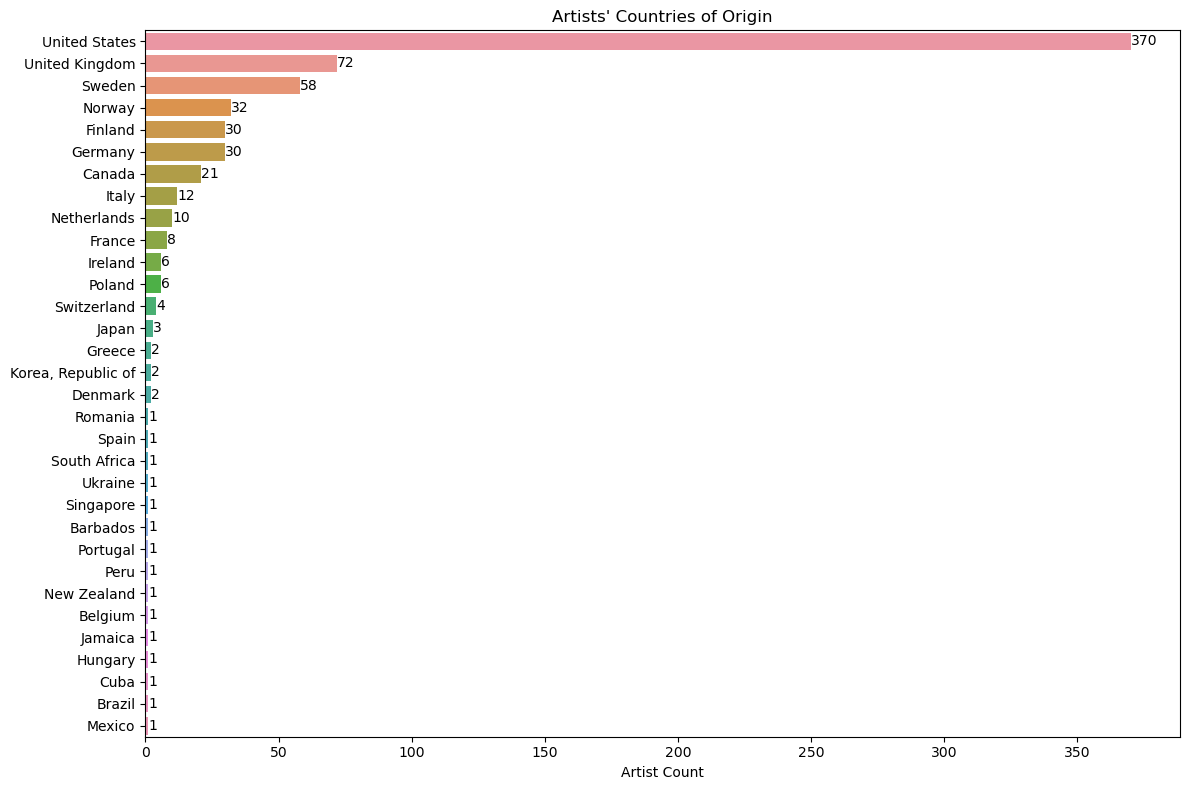

In [145]:

artists_copy_df = artists_df.copy()
artists_grouped_df = artists_copy_df.groupby(by='origin').agg(artist_count=('artist', 'count'))
artists_grouped_df = artists_grouped_df.reset_index()
artists_grouped_df.head()

fig, ax = plt.subplots(1, figsize=(12, 8))

plot = sns.barplot(artists_grouped_df.sort_values('artist_count', ascending=False), y='origin', x='artist_count', ax=ax)
plot.bar_label(plot.containers[0])
plot.set(ylabel=None)
plot.set(xlabel="Artist Count")
plot.set(title="Artists' Countries of Origin")

plt.tight_layout()
plt.show()


In [146]:

countries = artists_grouped_df[artists_grouped_df['artist_count']>=10]
countries_list = countries['origin'].to_list()

# Select artists in countries
artists_filter_countries_df = artists_df[artists_df['origin'].isin(countries_list)]


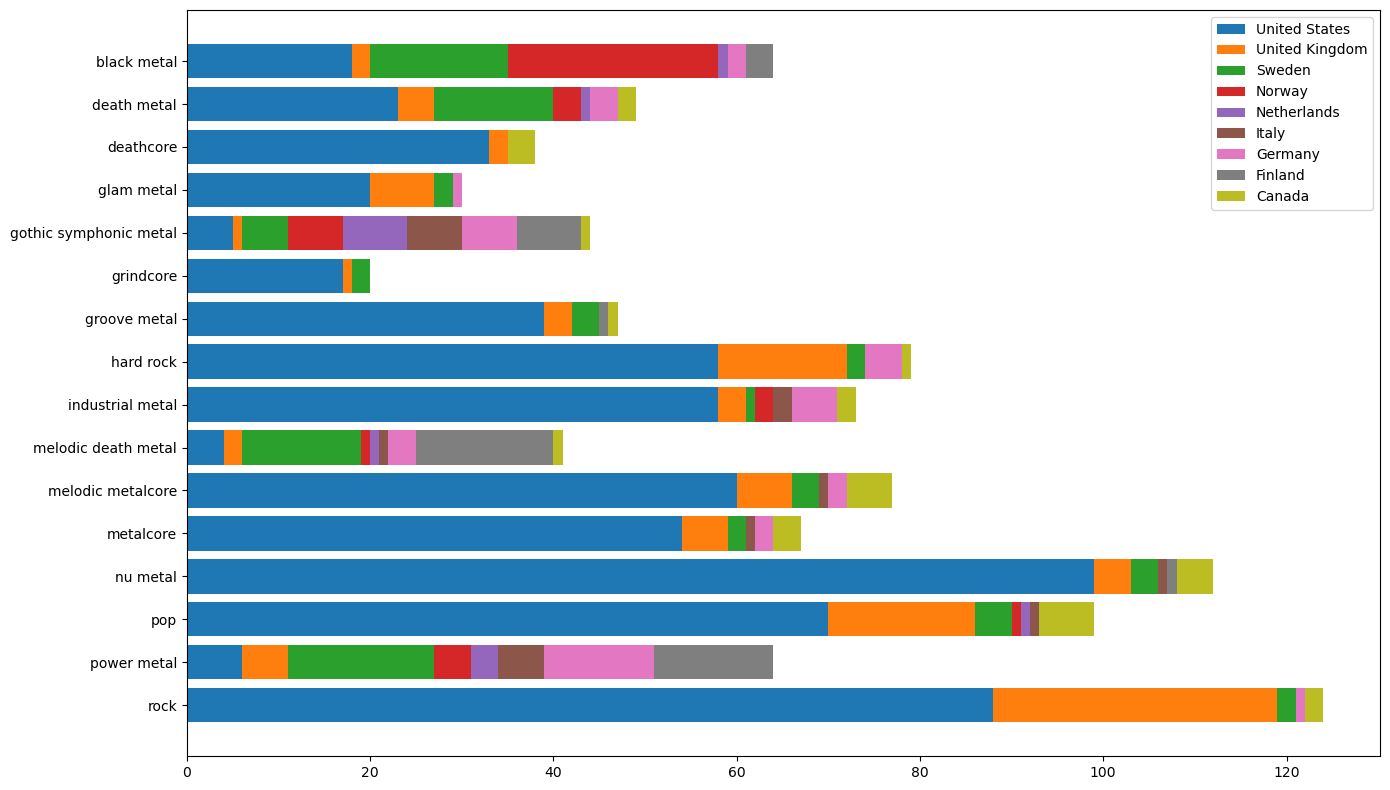

In [147]:

def create_barplot(unique_genres, unique_countries, data_df, value_col, ax):
    bottom_vals = len(unique_genres)*[0]

    # https://python-charts.com/part-whole/stacked-bar-chart-matplotlib/
    for j in range(len(unique_countries)):
        country = unique_countries[j]
        artists_list = []
        for i in range(len(unique_genres)):
            genre = unique_genres[i]

            num_artists = data_df[(data_df['genre']==genre) & (data_df['origin']==country)][value_col].values

            if (len(num_artists)>0):
                artists_val = num_artists[0]
            else:
                artists_val = 0

            artists_list += [artists_val]

        # ax[index].barh(unique_genres, artists_list, left=bottom_vals, label=country)
        ax.barh(unique_genres, artists_list, left=bottom_vals, label=country)

        for i in range(len(artists_list)):
            bottom_vals[i] += artists_list[i]

    ax.legend()


# Explode dataframe on genre
artist_genres_df = artists_filter_countries_df.explode('genres')
artist_genres_df.rename(columns={'genres':'genre'}, inplace=True)

# Calculate artist counts per genre for each country of origin
grouped_df = artist_genres_df.groupby(['genre', 'origin']).agg(artist_count=('artist', 'count'))
grouped_df.reset_index(inplace=True)

# Calculate percentage artists dataframe
grouped_frac_df = grouped_df.copy()
grouped_frac_df = grouped_frac_df.merge(grouped_frac_df.groupby('origin').sum(numeric_only=True).reset_index(), on='origin')
grouped_frac_df['percentage_artists'] = (grouped_frac_df['artist_count_x']/grouped_frac_df['artist_count_y'])

unique_genres = np.unique(grouped_df['genre'])
unique_countries = np.unique(grouped_df['origin'])

unique_genres.sort()
unique_countries.sort()

unique_genres = unique_genres[::-1]
unique_countries = unique_countries[::-1]

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

create_barplot(unique_genres, unique_countries, grouped_df, 'artist_count', ax)
plt.tight_layout()
plt.show()



In [148]:

genre_country_df = grouped_frac_df[['genre', 'origin', 'percentage_artists']].pivot(index ='origin', columns ='genre')
genre_country_df = genre_country_df*100
genre_country_df['total'] = genre_country_df.sum(axis=1)
genre_country_df = genre_country_df.round(1)
genre_country_df.head(20)


percentage_artists                                   \
genre                 black metal death metal deathcore glam metal   
origin                                                               
Canada                        NaN         6.5       9.7        NaN   
Finland                       7.5         NaN       NaN        NaN   
Germany                       4.9         7.3       NaN        2.4   
Italy                         NaN         NaN       NaN        NaN   
Netherlands                   7.1         7.1       NaN        NaN   
Norway                       57.5         7.5       NaN        NaN   
Sweden                       17.4        15.1       NaN        2.3   
United Kingdom                1.9         3.8       1.9        6.6   
United States                 2.8         3.5       5.1        3.1   

                                                                        \
genre          gothic symphonic metal grindcore groove metal hard rock   
origin                                                                   
Canada                            3.2       NaN          3.2       3.2   
Finland                          17.5       NaN          2.5       NaN   
Germany                          14.6       NaN          NaN       9.8   
Italy                            33.3       NaN          NaN       NaN   
Netherlands                      50.0       NaN          NaN       NaN   
Norway                           15.0       NaN          NaN       NaN   
Sweden                            5.8       2.3          3.5       2.3   
United Kingdom                    0.9       0.9          2.8      13.2   
United States                     0.8       2.6          6.0       8.9   

                                                                       \
genre          industrial metal melodic death metal melodic metalcore   
origin                                                                  
Canada                      6.5                 3.2              16.1   
Finland                     NaN                37.5               NaN   
Germany                    12.2                 7.3               4.9   
Italy                      11.1                 5.6               5.6   
Netherlands                 NaN                 7.1               NaN   
Norway                      5.0                 2.5               NaN   
Sweden                      1.2                15.1               3.5   
United Kingdom              2.8                 1.9               5.7   
United States               8.9                 0.6               9.2   

                                                           total  
genre          metalcore nu metal   pop power metal  rock         
origin                                                            
Canada               9.7     12.9  19.4         NaN   6.5  100.0  
Finland              NaN      2.5   NaN        32.5   NaN  100.0  
Germany              4.9      NaN   NaN        29.3   2.4  100.0  
Italy                5.6      5.6   5.6        27.8   NaN  100.0  
Netherlands          NaN      NaN   7.1        21.4   NaN  100.0  
Norway               NaN      NaN   2.5        10.0   NaN  100.0  
Sweden               2.3      3.5   4.7        18.6   2.3  100.0  
United Kingdom       4.7      3.8  15.1         4.7  29.2  100.0  
United States        8.3     15.2  10.7         0.9  13.5  100.0

In [149]:

country_genre_dict = {
    'Canada':           'melodic metalcore',
    'Finland':          'melodic death metal',
    'Germany':          'power metal',
    'Italy':            'gothic symphonic metal',
    'Netherlands':      'gothic symphonic metal',
    'Norway':           'black metal',
    'Sweden':           'death metal',
    'United Kingdom':   'glam metal',
    'United States':    'nu metal'
}

cols_tuple_list = []
data_list = []
for country in country_genre_dict:
    genre = country_genre_dict[country]
    genre_tuple = (country, genre)
    listeners_tuple = (country, 'monthly listeners (million)')
    cols_tuple_list += [genre_tuple]
    cols_tuple_list += [listeners_tuple]

    df = artist_genres_df[(artist_genres_df['origin']==country) & (artist_genres_df['genre']==genre)].sort_values('monthly_listeners', ascending=False).head(5)
    df['monthly_listeners'] = df['monthly_listeners']/1000000.0
    data_list += [df[['artist', 'monthly_listeners']].values]


df_data_list = []
for i in range(len(data_list[0])):
    df_data_list += [[]]
    for j in range(len(data_list)):
        for val in data_list[j][i]: df_data_list[i]+=[val]

genre_listens_df = pd.DataFrame(df_data_list, columns=pd.MultiIndex.from_tuples(cols_tuple_list)).round(2)
genre_listens_df.head(10)



Canada                                         Finland  \
      melodic metalcore monthly listeners (million) melodic death metal   
0             Spiritbox                        1.65   Children Of Bodom   
1           Silverstein                        1.64           Insomnium   
2          Counterparts                        0.36           Ensiferum   
3         Despised Icon                        0.07           Wintersun   
4  Beneath The Massacre                        0.01           Sentenced   

                                      Germany                              \
  monthly listeners (million)     power metal monthly listeners (million)   
0                        0.95       Powerwolf                        1.49   
1                        0.22          Accept                        1.36   
2                        0.21       Helloween                        1.33   
3                        0.19  Blind Guardian                        0.76   
4                        0.15       Avantasia                        0.70   

                   Italy                                        Netherlands  \
  gothic symphonic metal monthly listeners (million) gothic symphonic metal   
0            Lacuna Coil                        0.79      Within Temptation   
1              Elvenking                        0.25                  Epica   
2       Rhapsody Of Fire                        0.23                 Delain   
3           Frozen Crown                        0.05             Blackbriar   
4  Theatres Des Vampires                        0.02          After Forever   

                                     Norway                              \
  monthly listeners (million)   black metal monthly listeners (million)   
0                        2.33  Dimmu Borgir                        0.49   
1                        0.73        Burzum                        0.24   
2                        0.30     Satyricon                        0.22   
3                        0.25      Immortal                        0.20   
4                        0.18         Ulver                        0.16   

              Sweden                             United Kingdom  \
         death metal monthly listeners (million)     glam metal   
0         Arch Enemy                        1.07  Ozzy Osbourne   
1         Dissection                        0.38    Def Leppard   
2  Dark Tranquillity                        0.29     Whitesnake   
3       At The Gates                        0.26   Judas Priest   
4           Entombed                        0.24       Nazareth   

                                  United States                              
  monthly listeners (million)          nu metal monthly listeners (million)  
0                        9.46       Linkin Park                       34.13  
1                        7.68  System Of A Down                       17.31  
2                        5.77       Limp Bizkit                       13.62  
3                        4.96          Slipknot                       11.84  
4                        2.81        Papa Roach                       11.45


## Inspecting Tracks Data


In [ ]:

artists_filter_countries_df
tracks_all_df
tracks_kaggle_df

In [136]:

artists_filter_countries_df.head()
tracks_all_df.head()


,artist,track,track_id,track_listens,popularity,artist_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,lyrics,language
0,Rob Zombie,Dragula,6Nm8h73ycDG2saCnZV8poF,331646321,80,3HVdAiMNjYrQIKlOGxoGh5,0.591,0.963,0,-6.489,0,0.0531,0.000087,0.000107,0.0781,0.609,125.030,4,"Superstition, fear, and jealousy. Dead I am th...",english
1,Rob Zombie,Living Dead Girl,10V8XpuyMoEcSMfM79WDET,130584774,72,3HVdAiMNjYrQIKlOGxoGh5,0.518,0.948,6,-5.580,0,0.0683,0.005040,0.104000,0.2280,0.550,103.025,4,"""Who is this irresistible creature who has an ...",english
2,Rob Zombie,Superbeast,4eNnMvUrSu2TRpySjVC0Pv,91715788,68,3HVdAiMNjYrQIKlOGxoGh5,0.518,0.975,8,-4.425,1,0.0575,0.000136,0.827000,0.4200,0.320,154.059,4,Shriek the lips across a ragged tongue. Convul...,english
4,Rob Zombie,The Satanic Rites of Blacula,1JeGX4cixemJfBJl6XGQES,10284300,64,3HVdAiMNjYrQIKlOGxoGh5,0.480,0.993,0,-6.402,0,0.0862,0.000339,0.000050,0.3000,0.589,154.991,4,"Whoa, whoa, whoa, whoa, whoa, hold it, hold it...",english
6,Marilyn Manson,Sweet Dreams (Are Made Of This),2302lUwfZ4S4dVyPOCDFnQ,328158718,71,2VYQTNDsvvKN9wmU5W7xpj,0.392,0.642,8,-5.267,1,0.0326,0.004800,0.486000,0.2960,0.129,92.698,4,Sweet dreams are made of this. Who am I to dis...,english


In [ ]:

# genre against spotify stats
# pairwise of some features
# ? feature comparison between countries for same genres: death metal in UK vs death metal in sweden
# Youtube stats
# wordclouds


In [ ]:

# Sentiment
# Bert
# Popularity predictor
# Genre predictor


In [ ]:
# plt.show()


# d = pd.DataFrame.from_dict({
#     'country':['A', 'A', 'B', 'B'],
#     'type':['meme', 'tiktok', 'meme', 'tiktok'],
#     'value':[1, 2, 1, 3]
# })
# d.head()

# fig, ax = plt.subplots(1, figsize=(12, 8))
# plot = sns.barplot(d[d['type']=='meme'], y='value', x='country', ax=ax, color='lightblue', label='meme')
# plot.bar_label(plot.containers[0])
# plot = sns.barplot(d[d['type']=='tiktok'], y='value', x='country', bottom=d[d['type']=='meme']['value'], ax=ax, color='blue', label='tiktok')
# plot.bar_label(plot.containers[1])
# plt.show()





# right_plot = sns.boxplot(artists_df, y='origin', x='monthly_listeners', flierprops=dict(marker='o', markersize=1), order=artists_plt_df.sort_values('artist_count', ascending=False)['origin'], ax=ax[1])
# right_plot.set(yticklabels=[])
# right_plot.set(ylabel=None)

# # right_plot.yaxis.tick_right()
# # right_plot.invert_xaxis()
# # right_plot.set_xscale('log')

# plt.tight_layout()
# plt.show()

In [167]:

artists_expl_df = artists_df.explode('genres')
artists_expl_df.head(10)


,artist,id,monthly_listeners,description,followers,genres,origin,active_start,active_end
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,alternative metal,United States,1985,2023
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,hard rock,United States,1985,2023
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,industrial metal,United States,1985,2023
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,industrial rock,United States,1985,2023
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,nu metal,United States,1985,2023
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,post-grunge,United States,1985,2023
0,Rob Zombie,3HVdAiMNjYrQIKlOGxoGh5,5758128,The longtime frontman for '90s industrial supe...,2645445,rock,United States,1985,2023
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj,6735459,Controversial rock frontman Marilyn Manson bec...,4076257,alternative metal,United States,1989,2023
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj,6735459,Controversial rock frontman Marilyn Manson bec...,4076257,hard rock,United States,1989,2023
1,Marilyn Manson,2VYQTNDsvvKN9wmU5W7xpj,6735459,Controversial rock frontman Marilyn Manson bec...,4076257,industrial,United States,1989,2023


In [35]:
# https://wandb.ai/mukilan/BERT_Sentiment_Analysis/reports/An-Introduction-to-BERT-And-How-To-Use-It--VmlldzoyNTIyOTA1

import torch
import pandas as pd
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification


tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

def sentiment_movie_score(movie_review):
    token = tokenizer.encode(movie_review, return_tensors = 'pt')
    result = model(token)
#     return int(torch.argmax(result.logits))+1
    return result.logits
print(sentiment_movie_score('Brilliantly bad movie'))


RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
dlopen(/Users/carelburger/Documents/env/lib/python3.8/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): symbol not found in flat namespace '__ZN10tensorflow8internal10LogMessage16VmoduleActivatedEPKci'

tensor([[ 2.2494,  0.4025, -0.7081, -1.3131, -0.5004]],
       grad_fn=<AddmmBackward0>)


In [45]:


# 'Industrial Metal': '37i9dQZF1DX29LQDcJ6Xy7',
# 'INDUSTRIAL METAL': '0I4fAd7K0zIHBJYNw9fSuv',
# 'Heavy Metal': '37i9dQZF1DX9qNs32fujYe',
# 'Metal Mix': '37i9dQZF1EQpgT26jgbgRI',
# 'Aggressive Heavy Metal Mix': '37i9dQZF1EIetewBshGEPK',
# 'Death Metal Mix': '37i9dQZF1EIf78r65WuXwA',
# 'Death Metal Melodico': '5LXjHUJXPJIW71ySYppK5J',
# 'Death Metal': '2vivknVOeJD7BUYnnuztrE',
# 'Hard Rock': '37i9dQZF1DX1X7WV84927n',
# 'Hard Rock / Metal': '1GXRoQWlxTNQiMNkOe7RqA',
# 'Hard Rock Mix': '37i9dQZF1EIehdyB47Vd7I',
# 'Metalcore Mix': '37i9dQZF1EIgtj4OvJCT7Q',
# '2023 Metalcore Playlist': '7IUlbEWRYOKeTZKmjBcRgX',
# 'Modern Metalcore': '4ge2kKhU0ryYD1BWN1CX2T',
# 'Deathcore': '37i9dQZF1DX1cJWWyylDuw',
# 'Melodic Metal Mix': '37i9dQZF1EId4LkhIN52c3',
# 'Epic and Melodic': '37i9dQZF1DX37bXS7EGI3f',
# 'Melodic Death Metal Mix': '37i9dQZF1EIfs512qHK0fg',
# 'Grindcore Mix': '37i9dQZF1EIgFHBMi7n4aZ',
# 'Power Metal Mix': '37i9dQZF1EIfUrKSfi4vkq',
# 'power metal': '6uD6LqbKgMn036cfvniRO6',
# 'BLACK METAL': '37i9dQZF1EIdrDO1pClEMb',
# 'black metal classics': '688iTCqxHbpNbBuWplfa17',
# 'Nu Metal Era': '37i9dQZF1DXcfZ6moR6J0G',
# 'Nu Metal Mix': '37i9dQZF1EIdT6waU1nlDF',
# 'Nu Metal Hits': '37i9dQZF1EIdT6waU1nlDF',
# 'Ultimate Goth Metal': '1DR4lUIiCmTYWrxmMNSoyd',
# 'Gothic Metal': '76PSrknbBdEiQxvoinpYAm',
# 'Groove Metal Mix': '37i9dQZF1EIcCL8b99YRCA',
# 'Ultimate Groove Metal': '24y2slE56YDOTR2t4Zr1lR',
# 'Rock Mix': '37i9dQZF1EQpj7X7UK8OOF',
# 'Best of Rock 2000': '37i9dQZF1DX6rsDrBNGuWW',
# 'Pop Hits 2000s - 2023': '6mtYuOxzl58vSGnEDtZ9uB',
# 'Pop Hits 2023': '5TDtuKDbOhrfW7C58XnriZ',
# 'Pop Mix': '37i9dQZF1EQncLwOalG3K7'

# allowed_genres = [
#     'industrial metal',
#     'alternative metal',
#     'glam metal',
#     'death metal',
#     'hard rock',
#     'rock',
#     'metalcore',
#     'deathcore',
#     'melodic metalcore',
#     'melodic death metal',
#     'grindcore',
#     'power metal',
#     'black metal',
#     'nu metal',
#     'gothic metal',
#     'gothic symphonic metal',
#     'groove metal',
#     'pop',
#     'pop rock',
#     'dance pop',
# ]

# all_genres_dict = {}

# genres_series = artists_cleaned_df['genres'].values.tolist()
# for genre_list in genres_series:
#     for genre in genre_list:
#         if (genre not in all_genres_dict):
#             all_genres_dict[genre] = 1
#         else:
#             all_genres_dict[genre] += 1

# for genre in all_genres_dict:
#     print(genre, all_genres_dict[genre])



In [ ]:

# Todo
- explain different features in depth
- git stuff
- pip freeze
- how to reproduce
- add disclaimer that I don't necassarily subscribe to topics depicted
- add robots.txt stuff and being allowed to scrape and extract data
- disclaimer that there might be lyrics and names related to harsh topics
- add section on all the coursework topics covered in this assignment
- add comments and clean cell outputs
- make repo public and add repo link into notebook!!!

# Future work
- fans liked graphs
- better genre definitions [currently we are associating artists' genres to tracks, which might not always be the case]
- artists can have more than one genre, we count them multiple times


In [ ]:
# https://stackoverflow.com/questions/61064454/beautifulsoup-is-unable-to-extract-all-html